## Introduction 

In this project, our goal was to predict stock prices using a machine learning approach. To achieve this, we designed and implemented a model based on a set of carefully chosen features. These features included technical indicators such as Relative Strength Index (RSI), Money Flow Index (MFI), Exponential Moving Averages (EMA), Simple Moving Average (SMA),Moving Average Convergence Divergence (MACD) as well as historical price data encompassing the previous 1 day, 3 days, 5 days, and 1, 2, 3, 4 weeks. Additionally, rolling average values for high, low, open, close, adjusted close, and volume were incorporated.

## Import Libraries

In [1]:
import os
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor 
from catboost import CatBoostRegressor


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
pd.set_option('display.max_columns', None)


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
#init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore")

## Functions

In [2]:
def evaluate_regression_model(y_true, y_pred):
    """
    Calculate and print evaluation metrics for a regression model.

    Parameters:
    - y_true: Actual values.
    - y_pred: Predicted values.

    Returns:
    - Dictionary containing the evaluation metrics.
    """
    # Calculate evaluation metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Print the results
    print(f'Mean Squared Error (MSE): {np.round(mse,3)}')
    print(f'Root Mean Squared Error (RMSE): {np.round(rmse,3)}')
    print(f'Mean Absolute Error (MAE): {np.round(mae,3)}')
    print(f'R-squared (R2): {np.round(r2,3)}')

    # Return results as a dictionary
    results = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    return results

In [3]:
def evaluate_regression_model2(y_true, y_pred):
    """
    Calculate and print evaluation metrics for a regression model.

    Parameters:
    - y_true: Actual values.
    - y_pred: Predicted values.

    Returns:
    - Dictionary containing the evaluation metrics.
    """
    # Calculate evaluation metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

#     # Print the results
#     print(f'Mean Squared Error (MSE): {np.round(mse,3)}')
#     print(f'Root Mean Squared Error (RMSE): {np.round(rmse,3)}')
#     print(f'Mean Absolute Error (MAE): {np.round(mae,3)}')
#     print(f'R-squared (R2): {np.round(r2,3)}')

    # Return results as a dictionary
    results = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    return results

In [4]:
# Returns RSI values
def rsi(df, periods = 14):
    
    """
    Calculate the Relative Strength Index (RSI) for a given DataFrame.

    Parameters:
    - df (DataFrame): Pandas DataFrame with a 'close' column.
    - periods (int): Number of periods to consider for RSI calculation. Default is 14.

    Returns:
    - Series: A pandas Series containing the RSI values.
    """
        
        
    close = df['close']
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [5]:
def gain(x):
    return ((x > 0) * x).sum()


def loss(x):
    return ((x < 0) * x).sum()


def mfi(df, n=14):
    """
    Calculate the Money Flow Index (MFI) for a given DataFrame.

    Parameters:
    - df (DataFrame): Pandas DataFrame with 'high', 'low', 'close', and 'volume' columns.
    - n (int): Number of periods to use for the MFI calculation. Default is 14.

    Returns:
    - numpy.ndarray: An array containing the MFI values.
    """
    
    high = df['high']
    low = df['low']
    close = df['close']
    volume = df['volume']
    
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign

    # Calculate gain and loss using vectorized operations
    positive_mf = np.where(signed_mf > 0, signed_mf, 0)
    negative_mf = np.where(signed_mf < 0, -signed_mf, 0)

    mf_avg_gain = pd.Series(positive_mf).rolling(n, min_periods=1).sum()
    mf_avg_loss = pd.Series(negative_mf).rolling(n, min_periods=1).sum()

    return (100 - 100 / (1 + mf_avg_gain / mf_avg_loss)).to_numpy()

In [6]:
def plot_regression_accuracy(y_true, y_pred):
    """
    Create various plots to evaluate the accuracy of a linear regression model.

    Parameters:
    - y_true: Actual values.
    - y_pred: Predicted values.
    """
    # Scatter Plot
    plt.scatter(y_true, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot of Actual vs Predicted Values')
    plt.show()

    # Residual Plot
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    # Distribution of Residuals
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.show()

    # Predicted vs Actual Line
    plt.plot(y_true, y_true, linestyle='--', color='r', label='Perfect Fit')
    plt.scatter(y_true, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual Values with Perfect Fit Line')
    plt.legend()
    plt.show()


In [7]:
def plot_predictions(df,prediction):
    
    """
    Create a Plotly graph to compare actual values with predictions.

    Parameters:
    - df (DataFrame): A pandas DataFrame containing 'date' and 'close_1d_next' columns.
    - prediction (array-like): Predicted values corresponding to the test set.
    """
        
    plot_test_df= df[df.date.dt.year>=2020]
    plot_test_df['prediction'] = prediction

    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.date, y=df.close_1d_next,
                             name='Truth',
                             marker_color='LightSkyBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x=plot_test_df.date,
                             y=plot_test_df.prediction,
                             name='Prediction',
                             marker_color='MediumPurple'), row=1, col=1)
    
    # Add title and Y-axis title for the first subplot
    fig.update_layout(title_text='Train Data and Test Data', title_x=0.5, title_y=0.9)
    fig.update_yaxes(title_text='Prediction', row=1, col=1)

    fig.add_trace(go.Scatter(x=plot_test_df.date,
                             y=y_test,
                             name='Truth',
                             marker_color='LightSkyBlue',
                             showlegend=False), row=2, col=1)

    fig.add_trace(go.Scatter(x=plot_test_df.date,
                             y=prediction,
                             name='Prediction',
                             marker_color='MediumPurple',
                             showlegend=False), row=2, col=1)
    
    fig.update_yaxes(title_text='Prediction', row=2, col=1)

    fig.show()

In [8]:
def plot_feature_importance(model,X_train,top_features):

    """
    Plot the feature importance from a linear regression model and return a sorted DataFrame of feature importances.

    Parameters:
    - model: A trained linear regression model with a coef_ attribute.
    - X_train (DataFrame): The DataFrame used to train the model, for feature names.
    - num_top_features (int): Number of top features to display.

    Returns:
    - DataFrame: Sorted DataFrame with features and their importance.
    """
    
    # Get feature importance scores (coefficients)
    feature_importance = model.coef_

    # Create a DataFrame to store feature names and importance scores
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(feature_importance)})

    # Sort features by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    top_features = top_features
    # Plot feature importance
    plt.figure(figsize=(20, 6))
    plt.barh(range(len(feature_importance_df[:top_features])), feature_importance_df[:top_features]['Importance'], align="center")
    plt.yticks(range(len(feature_importance_df[:top_features])), labels=feature_importance_df[:top_features]['Feature'])
    plt.ylabel("Features")
    plt.xlabel("Coefficient Magnitude")
    plt.title(f"Top {top_features} Feature Importance Values")
    plt.show()
    
    return feature_importance_df

# Read Data

In [9]:
out_loc  = '/Users/isapocan/Desktop/LSU/data/'
# Define the file path for the parquet file
parquet_file_path = out_loc + "stock_1d.parquet"

In [10]:
try:
    # Read the Parquet file into a DataFrame
    df = pd.read_parquet(parquet_file_path)

    # Convert column names to lowercase for consistency
    df.columns = df.columns.str.lower()

    # Display the first few rows of the DataFrame
    display(df.head())

except Exception as e:
    print(f"An error occurred while reading the file: {e}")

date       open       high        low      close  adj close  \
0 2013-01-02  94.190002  94.790001  93.959999  94.779999  67.895119   
1 2013-01-03  94.339996  94.930000  94.129997  94.669998  67.816322   
2 2013-01-04  94.790001  95.480003  94.540001  95.370003  68.317757   
3 2013-01-07  95.019997  95.730003  94.760002  95.489998  68.403717   
4 2013-01-08  95.169998  95.750000  95.099998  95.500000  68.410889   

      volume symbol security  gics sector         gics sub-industry  \
0  3206700.0    MMM       3M  Industrials  Industrial Conglomerates   
1  2704600.0    MMM       3M  Industrials  Industrial Conglomerates   
2  2704900.0    MMM       3M  Industrials  Industrial Conglomerates   
3  2745800.0    MMM       3M  Industrials  Industrial Conglomerates   
4  2655500.0    MMM       3M  Industrials  Industrial Conglomerates   

   headquarters location  date added    cik founded  
0  Saint Paul, Minnesota  1957-03-04  66740    1902  
1  Saint Paul, Minnesota  1957-03-04  66740    1902  
2  Saint Paul, Minnesota  1957-03-04  66740    1902  
3  Saint Paul, Minnesota  1957-03-04  66740    1902  
4  Saint Paul, Minnesota  1957-03-04  66740    1902

## Select Stock

In [11]:
# Filter the DataFrame to include only rows where 'symbol' is 'MDLZ'
df = df[df['symbol']=='MDLZ']

# Display the first few rows and the shape of the filtered DataFrame
display(df.head())
display(df.shape)

date       open       high        low      close  adj close  \
852843 2013-01-02  25.840000  26.690001  25.780001  26.670000  21.445908   
852844 2013-01-03  26.700001  26.770000  26.490000  26.639999  21.421791   
852845 2013-01-04  26.700001  26.830000  26.549999  26.740000  21.502203   
852846 2013-01-07  26.620001  26.740000  26.549999  26.660000  21.437866   
852847 2013-01-08  26.520000  26.920000  26.459999  26.680000  21.453959   

            volume symbol                security       gics sector  \
852843  17862400.0   MDLZ  Mondelez International  Consumer Staples   
852844   9075500.0   MDLZ  Mondelez International  Consumer Staples   
852845   7696000.0   MDLZ  Mondelez International  Consumer Staples   
852846   7576200.0   MDLZ  Mondelez International  Consumer Staples   
852847  14360800.0   MDLZ  Mondelez International  Consumer Staples   

             gics sub-industry headquarters location  date added      cik  \
852843  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982   
852844  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982   
852845  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982   
852846  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982   
852847  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982   

       founded  
852843    2012  
852844    2012  
852845    2012  
852846    2012  
852847    2012

(2733, 15)

## 1. Feature engineering

### 1.a. Financial indicators

1. Relative Strength Index (RSI):

Description: RSI helps you understand if a stock is likely to be overbought (prices too high) or oversold (prices too low). It looks at recent price changes to make this determination.

2. Money Flow Index (MFI):

Description: MFI considers both price and trading volume to identify if a stock is overbought or oversold. It helps gauge the strength of buying and selling pressure.

3. Exponential Moving Average (EMA):

Description: EMA smoothens out price data, giving more weight to recent prices. It reacts faster to price changes compared to a Simple Moving Average (SMA), making it useful for trend analysis.

4. Simple Moving Average (SMA):

Description: SMA is a basic average of stock prices over a specific period. It provides a smoothed representation of the overall price trend, helping to identify general market direction.

5. Moving Average Convergence Divergence (MACD):

Description: MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It helps identify potential trend reversals or momentum shifts.

6. MACD Signal Line (MACD_signal):

Description: The MACD signal line is a nine-day EMA of the MACD. It is used to generate trading signals. When the MACD crosses above the signal line, it might be a signal to buy, and when it crosses below, it might be a signal to sell.

7. Lag and Rolling Average values of high, low, open, close, adjusted close, and volume.

In [12]:
def add_moving_averages(df, column_name):
    """
    Adds various moving averages to the DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame to modify.
    - column_name (str): The column name to calculate moving averages for.
    """
    # Exponential Moving Average (EMA)
    df['ema_9'] = df[column_name].ewm(span=9).mean().shift()

    # Simple Moving Averages (SMA) with different periods
    for period in [5, 10, 15, 30]:
        df[f'sma_{period}'] = df[column_name].rolling(window=period).mean().shift()

# Add moving averages for the 'close' column
add_moving_averages(df, 'close')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2733 entries, 852843 to 855575
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   2733 non-null   datetime64[ns]
 1   open                   2733 non-null   float64       
 2   high                   2733 non-null   float64       
 3   low                    2733 non-null   float64       
 4   close                  2733 non-null   float64       
 5   adj close              2733 non-null   float64       
 6   volume                 2733 non-null   float64       
 7   symbol                 2733 non-null   object        
 8   security               2733 non-null   object        
 9   gics sector            2733 non-null   object        
 10  gics sub-industry      2733 non-null   object        
 11  headquarters location  2733 non-null   object        
 12  date added             2733 non-null   object        
 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2733 entries, 852843 to 855575
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   2733 non-null   datetime64[ns]
 1   open                   2733 non-null   float64       
 2   high                   2733 non-null   float64       
 3   low                    2733 non-null   float64       
 4   close                  2733 non-null   float64       
 5   adj close              2733 non-null   float64       
 6   volume                 2733 non-null   float64       
 7   symbol                 2733 non-null   object        
 8   security               2733 non-null   object        
 9   gics sector            2733 non-null   object        
 10  gics sub-industry      2733 non-null   object        
 11  headquarters location  2733 non-null   object        
 12  date added             2733 non-null   object        
 

In [14]:
# Add a Relative Strength Index (RSI) column to the DataFrame
try:
    df['rsi'] = rsi(df) # Uncomment and adjust fillna(0) if appropriate for handling missing values
except Exception as e:
    print(f"Error calculating RSI: {e}")

# Add a Money Flow Index (MFI) column to the DataFrame
try:
    df['mfi'] = mfi(df, 14) # The second argument is the period, here assumed to be 14
except Exception as e:
    print(f"Error calculating MFI: {e}")

In [15]:
df[['date','close','ema_9','sma_5','sma_10','sma_15','sma_30','rsi','mfi']]

date      close      ema_9      sma_5     sma_10     sma_15  \
852843 2013-01-02  26.670000        NaN        NaN        NaN        NaN   
852844 2013-01-03  26.639999  26.670000        NaN        NaN        NaN   
852845 2013-01-04  26.740000  26.653333        NaN        NaN        NaN   
852846 2013-01-07  26.660000  26.688852        NaN        NaN        NaN   
852847 2013-01-08  26.680000  26.679078        NaN        NaN        NaN   
...           ...        ...        ...        ...        ...        ...   
855571 2023-11-02  67.970001  65.583879  65.934001  65.321001  64.406001   
855572 2023-11-03  68.820000  66.061103  66.398001  65.697001  64.868001   
855573 2023-11-06  68.239998  66.612883  67.160001  66.169001  65.354001   
855574 2023-11-07  68.489998  66.938306  67.612000  66.594001  65.728667   
855575 2023-11-08  69.019997  67.248644  68.067999  66.888000  66.058667   

           sma_30        rsi        mfi  
852843        NaN        NaN   0.000000  
852844        NaN        NaN  33.904295  
852845        NaN        NaN  48.695375  
852846        NaN        NaN  39.919745  
852847        NaN        NaN  55.233142  
...           ...        ...        ...  
855571  65.993000  60.257764  89.207420  
855572  65.901667  63.726091  89.458580  
855573  65.848000  59.885606  83.710782  
855574  65.799000  60.977252  75.937617  
855575  65.729667  63.259914  75.566164  

[2733 rows x 9 columns]

In [16]:
# Calculate and display the correlation between 'rsi' and 'mfi'
if {'rsi', 'mfi'}.issubset(df.columns):
    correlation = df[['rsi', 'mfi']].corr()
    print(correlation)
else:
    print("DataFrame does not contain 'rsi' and/or 'mfi' columns.")

          rsi       mfi
rsi  1.000000  0.698958
mfi  0.698958  1.000000


In [17]:
# calculating the Moving Average Convergence Divergence (MACD) and its signal line

# Ensure the 'close' column exists in the DataFrame
if 'close' in df.columns:
    # Calculate the 12-period EMA of the closing prices
    df['macd'] = df['close'].ewm(span=12, min_periods=12).mean() - df['close'].ewm(span=26, min_periods=26).mean()

    # Calculate the 9-period EMA of the MACD values (signal line)
    df['macd_signal'] = df['macd'].ewm(span=9, min_periods=9).mean()
else:
    print("DataFrame does not contain 'close' column.")

In [18]:
# Check if the required columns exist in the DataFrame
if {'macd', 'macd_signal'}.issubset(df.columns):
    # Select rows where 'macd' and 'macd_signal' columns do not have missing values
    filtered_df = df[(~df['macd'].isna()) & (~df['macd_signal'].isna())]
    
    # Display the first few rows of these columns
    print(filtered_df[['macd', 'macd_signal']].head())
else:
    print("DataFrame does not contain 'macd' and/or 'macd_signal' columns.")

            macd  macd_signal
852876 -0.147786    -0.050945
852877 -0.175230    -0.078792
852878 -0.198438    -0.104970
852879 -0.235462    -0.132994
852880 -0.226841    -0.152855


### 1.b. Shift Close price in order to predict next day

In [19]:
# Check if the required columns exist in the DataFrame
if {'date', 'close'}.issubset(df.columns):
    # Create a new column representing the next day's closing price
    df['close_1d_next'] = df['close'].shift(-1)

    # Display the first few rows including 'date', 'close', and 'close_1d_next'
    print(df[['date', 'close', 'close_1d_next']].head())
else:
    print("DataFrame does not contain 'date' and/or 'close' columns.")

             date      close  close_1d_next
852843 2013-01-02  26.670000      26.639999
852844 2013-01-03  26.639999      26.740000
852845 2013-01-04  26.740000      26.660000
852846 2013-01-07  26.660000      26.680000
852847 2013-01-08  26.680000      27.049999


### 1.c. Add lag features

In [20]:
def add_lagged_features(df, column_name, lags):
    """
    Adds lagged features for a specified column in the DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame to modify.
    - column_name (str): The column name to create lagged features for.
    - lags (list of int): The list of lag periods.
    """
    for lag in lags:
        df[f'{column_name}_{lag}d_ago'] = df[column_name].shift(lag)

def add_rolling_avg_features(df, column_name, windows):
    """
    Adds rolling average features for a specified column in the DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame to modify.
    - column_name (str): The column name to create rolling average features for.
    - windows (list of int): The list of rolling window sizes.
    """
    for window in windows:
        df[f'{column_name}_{window}d_avg'] = df[column_name].rolling(window=window).mean()

# Define lag periods and rolling window sizes
lag_periods = [1, 3, 5, 7, 14, 21, 28]
rolling_windows = [3, 5, 7, 10, 15, 30]

# Columns to create features for
columns = ['close', 'adj close', 'open', 'high', 'low', 'volume']

# Add lagged and rolling average features for each column
for column in columns:
    add_lagged_features(df, column, lag_periods)
    add_rolling_avg_features(df, column, rolling_windows)

# View the DataFrame
df.head()

date       open       high        low      close  adj close  \
852843 2013-01-02  25.840000  26.690001  25.780001  26.670000  21.445908   
852844 2013-01-03  26.700001  26.770000  26.490000  26.639999  21.421791   
852845 2013-01-04  26.700001  26.830000  26.549999  26.740000  21.502203   
852846 2013-01-07  26.620001  26.740000  26.549999  26.660000  21.437866   
852847 2013-01-08  26.520000  26.920000  26.459999  26.680000  21.453959   

            volume symbol                security       gics sector  \
852843  17862400.0   MDLZ  Mondelez International  Consumer Staples   
852844   9075500.0   MDLZ  Mondelez International  Consumer Staples   
852845   7696000.0   MDLZ  Mondelez International  Consumer Staples   
852846   7576200.0   MDLZ  Mondelez International  Consumer Staples   
852847  14360800.0   MDLZ  Mondelez International  Consumer Staples   

             gics sub-industry headquarters location  date added      cik  \
852843  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982   
852844  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982   
852845  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982   
852846  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982   
852847  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982   

       founded      ema_9  sma_5  sma_10  sma_15  sma_30  rsi        mfi  \
852843    2012        NaN    NaN     NaN     NaN     NaN  NaN   0.000000   
852844    2012  26.670000    NaN     NaN     NaN     NaN  NaN  33.904295   
852845    2012  26.653333    NaN     NaN     NaN     NaN  NaN  48.695375   
852846    2012  26.688852    NaN     NaN     NaN     NaN  NaN  39.919745   
852847    2012  26.679078    NaN     NaN     NaN     NaN  NaN  55.233142   

        macd  macd_signal  close_1d_next  close_1d_ago  close_3d_ago  \
852843   NaN          NaN      26.639999           NaN           NaN   
852844   NaN          NaN      26.740000     26.670000           NaN   
852845   NaN          NaN      26.660000     26.639999           NaN   
852846   NaN          NaN      26.680000     26.740000     26.670000   
852847   NaN          NaN      27.049999     26.660000     26.639999   

        close_5d_ago  close_7d_ago  close_14d_ago  close_21d_ago  \
852843           NaN           NaN            NaN            NaN   
852844           NaN           NaN            NaN            NaN   
852845           NaN           NaN            NaN            NaN   
852846           NaN           NaN            NaN            NaN   
852847           NaN           NaN            NaN            NaN   

        close_28d_ago  close_3d_avg  close_5d_avg  close_7d_avg  \
852843            NaN           NaN           NaN           NaN   
852844            NaN           NaN           NaN           NaN   
852845            NaN     26.683333           NaN           NaN   
852846            NaN     26.680000           NaN           NaN   
852847            NaN     26.693333        26.678           NaN   

        close_10d_avg  close_15d_avg  close_30d_avg  adj close_1d_ago  \
852843            NaN            NaN            NaN               NaN   
852844            NaN            NaN            NaN         21.445908   
852845            NaN            NaN            NaN         21.421791   
852846            NaN            NaN            NaN         21.502203   
852847            NaN            NaN            NaN         21.437866   

        adj close_3d_ago  adj close_5d_ago  adj close_7d_ago  \
852843               NaN               NaN               NaN   
852844               NaN               NaN               NaN   
852845               NaN               NaN               NaN   
852846         21.445908               NaN               NaN   
852847         21.421791               NaN               NaN   

        adj close_14d_ago  adj close_21d_ago  adj close_28d_ago  \
852843                NaN                NaN                NaN   
852844

### 1.d. Remove missing records after feature engineering

In [21]:
# Check if the DataFrame contains any missing values
if df.isna().any().any():
    # Remove records with missing values and reset the index
    df = df.dropna().reset_index(drop=True)
    print("Missing records removed. DataFrame is now cleaned.")
else:
    df = df.copy()
    print("No missing records found. DataFrame remains unchanged.")

# Display the first few rows of the cleaned DataFrame
df.head()

Missing records removed. DataFrame is now cleaned.


date       open       high        low      close  adj close  \
0 2013-02-20  27.070000  27.150000  26.950001  27.030001  21.735399   
1 2013-02-21  26.990000  27.049999  26.639999  26.820000  21.566534   
2 2013-02-22  26.889999  27.129999  26.730000  26.770000  21.526327   
3 2013-02-25  26.790001  27.080000  26.480000  26.490000  21.301172   
4 2013-02-26  26.530001  26.980000  26.510000  26.950001  21.671074   

       volume symbol                security       gics sector  \
0  17057200.0   MDLZ  Mondelez International  Consumer Staples   
1  16936600.0   MDLZ  Mondelez International  Consumer Staples   
2  16664800.0   MDLZ  Mondelez International  Consumer Staples   
3  15527100.0   MDLZ  Mondelez International  Consumer Staples   
4  13702900.0   MDLZ  Mondelez International  Consumer Staples   

        gics sub-industry headquarters location  date added      cik founded  \
0  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982    2012   
1  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982    2012   
2  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982    2012   
3  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982    2012   
4  Packaged Foods & Meats     Chicago, Illinois  2012-10-02  1103982    2012   

       ema_9   sma_5  sma_10     sma_15     sma_30        rsi        mfi  \
0  27.307926  27.136  27.518  27.642000  27.589000  41.633625  53.176274   
1  27.252312  27.006  27.426  27.588667  27.601333  38.257648  47.431888   
2  27.165815  26.820  27.308  27.528000  27.606000  37.478423  48.958416   
3  27.086626  26.860  27.181  27.460000  27.596667  33.378362  47.675126   
4  26.967270  26.814  27.054  27.344667  27.569333  44.181951  48.178912   

       macd  macd_signal  close_1d_next  close_1d_ago  close_3d_ago  \
0 -0.147786    -0.050945      26.820000     26.959999     26.570000   
1 -0.175230    -0.078792      26.770000     27.030001     26.719999   
2 -0.198438    -0.104970      26.490000     26.820000     26.959999   
3 -0.235462    -0.132994      26.950001     26.770000     27.030001   
4 -0.226841    -0.152855      27.570000     26.490000     26.820000   

   close_5d_ago  close_7d_ago  close_14d_ago  close_21d_ago  close_28d_ago  \
0     27.680000         27.76      27.730000      28.080000      27.049999   
1     27.750000         27.75      27.790001      27.559999      27.309999   
2     26.570000         27.68      28.219999      27.790001      27.420000   
3     26.719999         27.75      27.879999      27.830000      27.480000   
4     26.959999         26.57      27.950001      27.780001      27.709999   

   close_3d_avg  close_5d_avg  close_7d_avg  close_10d_avg  close_15d_avg  \
0     26.903333        27.006     27.208571         27.426      27.588667   
1     26.936666        26.820     27.075714         27.308      27.528000   
2     26.873334        26.860     26.945714         27.181      27.460000   
3     26.693333        26.814     26.765714         27.054      27.344667   
4     26.736667        26.812     26.820000         26.974      27.282667   

   close_30d_avg  adj close_1d_ago  adj close_3d_ago  adj close_5d_ago  \
0      27.601333         21.679117         21.365499         22.258080   
1      27.606000         21.735399         21.486118         22.314371   
2      27.596667         21.566534         21.679117         21.365499   
3      27.569333         21.526327         21.735399         21.486118   
4      27.553667         21.301172         21.566534         21.679117   

   adj close_7d_ago  adj close_14d_ago  adj close_21d_ago  adj close_28d_ago  \
0         22.322405          22.298285          22.579723          21.751484   
1         22.314371          22.346525          22.161583          21.960548   
2         22.258080          22.692308          22.346525          22.049007   
3         22.314371          22.418896          22.378695          22.097254   
4         21.365499          22.475189    

### 1.e. Split Data into Train ( before Covid ) and Test ( after Covid )

In [22]:
# # Calculate the index for the 70-30 split
# split_index = int(0.7 * len(df))

# # Split the DataFrame into training and testing sets
# train_df = df.iloc[:split_index]
# test_df = df.iloc[split_index:]

# Split the DataFrame into training and testing sets
train_df = df[df.date.dt.year<2020]
test_df = df[df.date.dt.year>=2020]



print(f"Train days: {len(train_df)}, Test days: {len(test_df)}")

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.date, y=train_df.close_1d_next, name='Training'))
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.close_1d_next,  name='Test'))
fig.show()

Train days: 1729, Test days: 970


In [23]:
drop_cols1 = ['date','open','high','low','close','adj close','volume','symbol','security',
 'gics sector','gics sub-industry','headquarters location','date added','cik','founded']

train_df = train_df.drop(drop_cols1, 1)

test_df  = test_df.drop(drop_cols1, 1)

# target column is next day's close price
y_train = train_df['close_1d_next'].copy()
X_train = train_df.drop(['close_1d_next'], 1)

# target column is next day's close price
y_test  = test_df['close_1d_next'].copy()
X_test  = test_df.drop(['close_1d_next'], 1)

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
X_train.shape, X_train_scaled.shape, X_test.shape, X_test_scaled.shape, 

((1729, 87), (1729, 87), (970, 87), (970, 87))

## 2. Train multiple regression models

In [26]:
def train_and_evaluate_models(X_train_scaled,y_train,X_test_scaled,y_test):
    """
    Train and evaluate multiple regression models on a given dataframe.

    Parameters:
    - dataframe: Pandas DataFrame containing the dataset.
    - target_column: Name of the target column (dependent variable).
    - features_columns: List of column names used as features (independent variables).

    Returns:
    - A DataFrame containing evaluation metrics for each model.
    """

    # Split the data into features (X) and target variable (y)
#     X = dataframe[features_columns]
#     y = dataframe[target_column]

    # Split the data into training and testing sets (70-30 split)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)


    # Initialize the models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Elastic Net': ElasticNet(),
        'SVR': SVR(),
        'K-Neighbors Regressor': KNeighborsRegressor(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'Gradient Boosting': GradientBoostingRegressor(),
        'AdaBoost': AdaBoostRegressor(),
        'XGBoost': XGBRegressor(),
        'CatBoost': CatBoostRegressor()
    }

    # Initialize a DataFrame to store the evaluation metrics
    metrics_df = pd.DataFrame(columns=['Model', 'Mean Squared Error', 'Mean Absolute Error', 'R2 Score'])

    # Train and evaluate each model
    for model_name, model in models.items():
        start_time = time.time() 
       
    # Train the model
        model.fit(X_train_scaled, y_train)
        
        end_time = time.time()  # Record the end time

        training_time = end_time - start_time

        # Make predictions
        y_pred = model.predict(X_test_scaled)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store the metrics in the DataFrame
        metrics_df = metrics_df.append({
            'Model': model_name,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2,
            'Training Time (s)': training_time
        }, ignore_index=True)
        metrics_df = metrics_df.sort_values(by=['R2 Score'],ascending=False)
    return metrics_df


In [27]:
df_compare = train_and_evaluate_models(X_train,y_train,X_test,y_test)

Learning rate set to 0.044643
0:	learn: 6.0603979	total: 63.2ms	remaining: 1m 3s
1:	learn: 5.8169612	total: 69.1ms	remaining: 34.5s
2:	learn: 5.5755845	total: 74ms	remaining: 24.6s
3:	learn: 5.3462380	total: 78.7ms	remaining: 19.6s
4:	learn: 5.1261132	total: 83.9ms	remaining: 16.7s
5:	learn: 4.9208602	total: 88.5ms	remaining: 14.7s
6:	learn: 4.7250714	total: 93.4ms	remaining: 13.2s
7:	learn: 4.5456470	total: 97.7ms	remaining: 12.1s
8:	learn: 4.3606091	total: 102ms	remaining: 11.3s
9:	learn: 4.1830096	total: 107ms	remaining: 10.6s
10:	learn: 4.0166823	total: 111ms	remaining: 10s
11:	learn: 3.8657076	total: 117ms	remaining: 9.62s
12:	learn: 3.7140111	total: 130ms	remaining: 9.84s
13:	learn: 3.5654097	total: 140ms	remaining: 9.83s
14:	learn: 3.4264460	total: 145ms	remaining: 9.54s
15:	learn: 3.2905647	total: 150ms	remaining: 9.22s
16:	learn: 3.1619168	total: 155ms	remaining: 8.95s
17:	learn: 3.0386276	total: 161ms	remaining: 8.76s
18:	learn: 2.9250019	total: 167ms	remaining: 8.61s
19:	lea

202:	learn: 0.4931395	total: 981ms	remaining: 3.85s
203:	learn: 0.4920884	total: 985ms	remaining: 3.85s
204:	learn: 0.4909474	total: 990ms	remaining: 3.84s
205:	learn: 0.4899796	total: 996ms	remaining: 3.84s
206:	learn: 0.4890645	total: 1s	remaining: 3.83s
207:	learn: 0.4882374	total: 1s	remaining: 3.82s
208:	learn: 0.4871172	total: 1.01s	remaining: 3.82s
209:	learn: 0.4861811	total: 1.01s	remaining: 3.81s
210:	learn: 0.4850126	total: 1.02s	remaining: 3.8s
211:	learn: 0.4837164	total: 1.02s	remaining: 3.8s
212:	learn: 0.4829656	total: 1.02s	remaining: 3.79s
213:	learn: 0.4819662	total: 1.03s	remaining: 3.78s
214:	learn: 0.4817394	total: 1.03s	remaining: 3.77s
215:	learn: 0.4811177	total: 1.04s	remaining: 3.77s
216:	learn: 0.4806224	total: 1.04s	remaining: 3.76s
217:	learn: 0.4800808	total: 1.05s	remaining: 3.75s
218:	learn: 0.4789126	total: 1.05s	remaining: 3.75s
219:	learn: 0.4784037	total: 1.05s	remaining: 3.74s
220:	learn: 0.4774369	total: 1.06s	remaining: 3.74s
221:	learn: 0.476452

379:	learn: 0.3840501	total: 1.77s	remaining: 2.88s
380:	learn: 0.3839565	total: 1.77s	remaining: 2.88s
381:	learn: 0.3834811	total: 1.78s	remaining: 2.88s
382:	learn: 0.3829302	total: 1.78s	remaining: 2.87s
383:	learn: 0.3824233	total: 1.79s	remaining: 2.87s
384:	learn: 0.3820862	total: 1.79s	remaining: 2.86s
385:	learn: 0.3817059	total: 1.79s	remaining: 2.86s
386:	learn: 0.3810940	total: 1.8s	remaining: 2.85s
387:	learn: 0.3807112	total: 1.8s	remaining: 2.85s
388:	learn: 0.3802605	total: 1.81s	remaining: 2.84s
389:	learn: 0.3798039	total: 1.81s	remaining: 2.83s
390:	learn: 0.3793238	total: 1.82s	remaining: 2.83s
391:	learn: 0.3787842	total: 1.82s	remaining: 2.83s
392:	learn: 0.3783469	total: 1.82s	remaining: 2.82s
393:	learn: 0.3774757	total: 1.83s	remaining: 2.81s
394:	learn: 0.3770911	total: 1.83s	remaining: 2.81s
395:	learn: 0.3767255	total: 1.84s	remaining: 2.8s
396:	learn: 0.3761264	total: 1.84s	remaining: 2.8s
397:	learn: 0.3757592	total: 1.85s	remaining: 2.79s
398:	learn: 0.37

561:	learn: 0.3108621	total: 2.55s	remaining: 1.99s
562:	learn: 0.3104885	total: 2.55s	remaining: 1.98s
563:	learn: 0.3103672	total: 2.56s	remaining: 1.98s
564:	learn: 0.3099546	total: 2.56s	remaining: 1.97s
565:	learn: 0.3094861	total: 2.57s	remaining: 1.97s
566:	learn: 0.3091734	total: 2.57s	remaining: 1.96s
567:	learn: 0.3089148	total: 2.58s	remaining: 1.96s
568:	learn: 0.3086673	total: 2.58s	remaining: 1.95s
569:	learn: 0.3082695	total: 2.58s	remaining: 1.95s
570:	learn: 0.3078891	total: 2.59s	remaining: 1.94s
571:	learn: 0.3074927	total: 2.59s	remaining: 1.94s
572:	learn: 0.3069862	total: 2.6s	remaining: 1.94s
573:	learn: 0.3064039	total: 2.6s	remaining: 1.93s
574:	learn: 0.3061550	total: 2.6s	remaining: 1.93s
575:	learn: 0.3056908	total: 2.61s	remaining: 1.92s
576:	learn: 0.3052593	total: 2.61s	remaining: 1.92s
577:	learn: 0.3049534	total: 2.62s	remaining: 1.91s
578:	learn: 0.3044688	total: 2.62s	remaining: 1.91s
579:	learn: 0.3041772	total: 2.63s	remaining: 1.9s
580:	learn: 0.30

740:	learn: 0.2568704	total: 3.33s	remaining: 1.16s
741:	learn: 0.2566573	total: 3.33s	remaining: 1.16s
742:	learn: 0.2564107	total: 3.34s	remaining: 1.16s
743:	learn: 0.2561631	total: 3.35s	remaining: 1.15s
744:	learn: 0.2561312	total: 3.35s	remaining: 1.15s
745:	learn: 0.2557099	total: 3.36s	remaining: 1.14s
746:	learn: 0.2554609	total: 3.36s	remaining: 1.14s
747:	learn: 0.2552453	total: 3.36s	remaining: 1.13s
748:	learn: 0.2549054	total: 3.37s	remaining: 1.13s
749:	learn: 0.2546371	total: 3.37s	remaining: 1.12s
750:	learn: 0.2543651	total: 3.38s	remaining: 1.12s
751:	learn: 0.2537761	total: 3.38s	remaining: 1.11s
752:	learn: 0.2535814	total: 3.39s	remaining: 1.11s
753:	learn: 0.2531956	total: 3.39s	remaining: 1.11s
754:	learn: 0.2531389	total: 3.39s	remaining: 1.1s
755:	learn: 0.2529298	total: 3.4s	remaining: 1.1s
756:	learn: 0.2527376	total: 3.4s	remaining: 1.09s
757:	learn: 0.2524734	total: 3.41s	remaining: 1.09s
758:	learn: 0.2521595	total: 3.41s	remaining: 1.08s
759:	learn: 0.25

919:	learn: 0.2151079	total: 4.12s	remaining: 358ms
920:	learn: 0.2149705	total: 4.12s	remaining: 353ms
921:	learn: 0.2149322	total: 4.12s	remaining: 349ms
922:	learn: 0.2148807	total: 4.13s	remaining: 344ms
923:	learn: 0.2146427	total: 4.13s	remaining: 340ms
924:	learn: 0.2145465	total: 4.14s	remaining: 335ms
925:	learn: 0.2143896	total: 4.14s	remaining: 331ms
926:	learn: 0.2141042	total: 4.15s	remaining: 327ms
927:	learn: 0.2140653	total: 4.15s	remaining: 322ms
928:	learn: 0.2138073	total: 4.16s	remaining: 318ms
929:	learn: 0.2135790	total: 4.16s	remaining: 313ms
930:	learn: 0.2135487	total: 4.16s	remaining: 309ms
931:	learn: 0.2134147	total: 4.17s	remaining: 304ms
932:	learn: 0.2132543	total: 4.17s	remaining: 300ms
933:	learn: 0.2131319	total: 4.18s	remaining: 295ms
934:	learn: 0.2128832	total: 4.18s	remaining: 291ms
935:	learn: 0.2125868	total: 4.18s	remaining: 286ms
936:	learn: 0.2124035	total: 4.19s	remaining: 282ms
937:	learn: 0.2121759	total: 4.19s	remaining: 277ms
938:	learn: 

In [28]:
df_compare

Model Mean Squared Error Mean Absolute Error  R2 Score  \
0        Ridge Regression           0.746614            0.598242   0.98175   
1       Linear Regression            0.77558            0.613905  0.981042   
2        Lasso Regression           1.066347            0.782536  0.973934   
3             Elastic Net           1.070319            0.718474  0.973837   
4       Gradient Boosting          87.489334            7.501632 -1.138585   
5                AdaBoost           88.43475            7.561282 -1.161695   
6           Random Forest          90.124875            7.670387 -1.203008   
7           Decision Tree          91.634349            7.746372 -1.239906   
11               CatBoost          93.180853            7.853729 -1.277709   
8                 XGBoost          94.682514            7.893578 -1.314415   
9   K-Neighbors Regressor         330.959365           16.750109 -7.089956   
10                    SVR         349.552891           17.672316 -7.544455   

    Training Time (s)  
0            0.002745  
1            0.015371  
2            0.104589  
3            0.108071  
4            2.444588  
5            0.786036  
6            4.302596  
7            0.079427  
11           4.704044  
8            0.665853  
9            0.000767  
10           0.150409

We trained a variety of regression models to predict stock prices, including Linear Regression, Ridge Regression, Lasso Regression, Elastic Net, Support Vector Regression (SVR), K-Neighbors Regressor, Decision Tree, Random Forest, Gradient Boosting, AdaBoost, XGBoost, and CatBoost. The training results show a variety of metrics for different regression models, which are useful in evaluating their performance. Let's break down what each metric means and its significance:

- **Mean Squared Error (MSE):**
MSE is a measure of the average squared difference between the actual and predicted values. The lower the MSE, the better the model's performance. A high MSE, as seen in models like SVR, Decision Tree, and Random Forest, indicates poor model performance. 


- **Mean Absolute Error (MAE):**
MAE measures the average magnitude of errors between predicted and actual values, without considering their direction (i.e., no squaring or rooting). Similar to MSE, a lower MAE is better. High MAE values in models like SVR suggest significant average errors in predictions. 


- **R2 Score:**
The R2 Score, or the coefficient of determination, measures how well the regression predictions approximate the real data points. An R2 Score of 1 indicates perfect prediction. Positive values close to 1 indicate good model performance. The Linear and Ridge Regression models have high R2 scores, implying they fit the data well. Negative R2 scores, as seen in SVR, K-Neighbors Regressor, Decision Tree, Random Forest, Gradient Boosting, and AdaBoost, indicate that these models perform worse than a simple model that would always predict the mean value of the target variable. 


- **Training Time (s):**
This measures how long it takes for each model to be trained. Shorter training times are generally preferred, especially when dealing with large datasets or in scenarios where model training needs to be performed frequently. The Random Forest model, for example, has a significantly longer training time compared to others, which might be a drawback in time-sensitive applications.


- **Analysis of Results:** 
Linear Regression and Ridge Regression show the best performance in terms of MSE, MAE, and R2 Score. They are also efficient with relatively low training times. Lasso Regression performs moderately well, with a reasonable R2 score but much higher MSE and MAE than Linear and Ridge Regression. Models like SVR, K-Neighbors Regressor, Decision Tree, Random Forest, Gradient Boosting, and AdaBoost have very poor R2 scores, indicating that they are not suitable for this particular dataset or require parameter tuning. The Random Forest model, despite its popularity for handling complex datasets, shows poor performance and extremely high training time in this case, which might be due to overfitting, the need for hyperparameter tuning, or the nature of the dataset.


- **Conclusion:** 
The choice of the best model depends on a balance of these metrics and the specific requirements of the application (e.g., prediction accuracy vs. training time). For this dataset, Linear Regression and Ridge Regression seem to be the most effective. However, for practical deployment, one should also consider factors like model complexity, interpretability, and how the model will generalize to unseen data.

## 3. Linear Regression Model

### 3.a Linear Regression Model with All Features

In [29]:
# Train the linear regression model
lr_model_base = LinearRegression()
lr_model_base.fit(X_train_scaled, y_train)

# Make predictions on the scaled test set
lr_pred_base = lr_model_base.predict(X_test_scaled)

In [30]:
prediction_df = pd.DataFrame()
prediction_df['date'] = df[df.date.dt.year>=2020]['date']
prediction_df['y_test'] = y_test
prediction_df['lr_pred_base'] = lr_pred_base

prediction_df.head()

date     y_test  lr_pred_base
1729 2020-01-02  54.240002     54.157799
1730 2020-01-03  54.150002     54.553547
1731 2020-01-06  53.919998     54.336899
1732 2020-01-07  54.049999     53.907121
1733 2020-01-08  54.189999     54.192608

In [31]:
lr_score_base = evaluate_regression_model(y_test, lr_pred_base)

Mean Squared Error (MSE): 0.776
Root Mean Squared Error (RMSE): 0.881
Mean Absolute Error (MAE): 0.614
R-squared (R2): 0.981


In [32]:
lr_score_base

{'MSE': 0.7755799343709945,
 'RMSE': 0.880670162076015,
 'MAE': 0.6139047642970673,
 'R2': 0.9810417591179742}

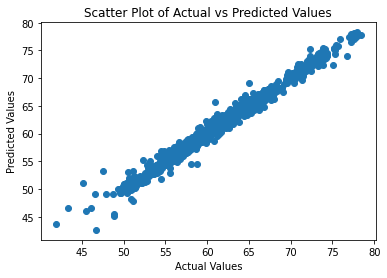

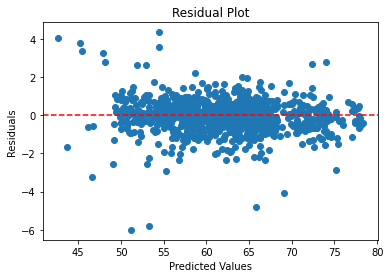

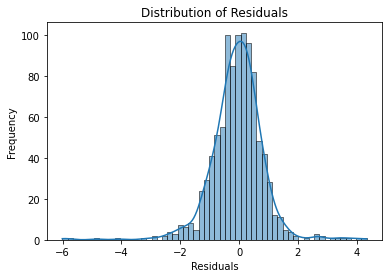

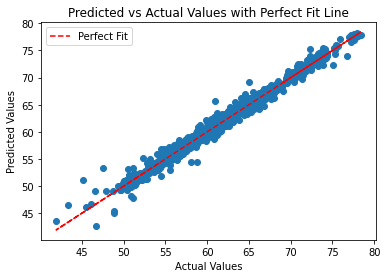

In [33]:
plot_regression_accuracy(y_test, lr_pred_base)

In [34]:
plot_predictions(df,lr_pred_base)

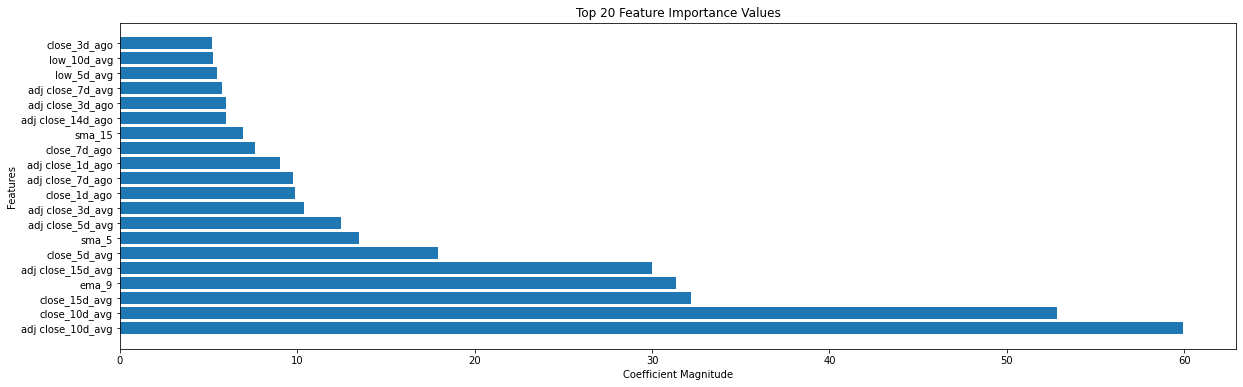

In [35]:
lr_base_feature_importance = plot_feature_importance(lr_model_base,X_train,20)

In [36]:
lr_base_feature_importance[:15]

Feature  Importance
0   adj close_10d_avg   59.927343
1       close_10d_avg   52.842967
2       close_15d_avg   32.217386
3               ema_9   31.326586
4   adj close_15d_avg   29.982687
5        close_5d_avg   17.929065
6               sma_5   13.495880
7    adj close_5d_avg   12.461717
8    adj close_3d_avg   10.395039
9        close_1d_ago    9.861051
10   adj close_7d_ago    9.733592
11   adj close_1d_ago    9.044414
12       close_7d_ago    7.605479
13             sma_15    6.911237
14  adj close_14d_ago    5.986732

### 3.b. Linear Regression Model with top 20 Features

In [37]:
keep_cols20 = lr_base_feature_importance[:20]['Feature'].tolist()

X_train20 = X_train[keep_cols20]
X_test20 = X_test[keep_cols20]

scaler = StandardScaler()
X_train_scaled20 = scaler.fit_transform(X_train20)
X_test_scaled20 = scaler.transform(X_test20)

In [38]:
# Train the linear regression model
lr_model20 = LinearRegression()
lr_model20.fit(X_train_scaled20, y_train)

# Make predictions on the scaled test set
lr_pred20 = lr_model20.predict(X_test_scaled20)
lr_score20 = evaluate_regression_model(y_test, lr_pred20)

Mean Squared Error (MSE): 0.768
Root Mean Squared Error (RMSE): 0.877
Mean Absolute Error (MAE): 0.613
R-squared (R2): 0.981


In [39]:
prediction_df['lr_pred20'] = lr_pred20

prediction_df.head()

date     y_test  lr_pred_base  lr_pred20
1729 2020-01-02  54.240002     54.157799  54.239022
1730 2020-01-03  54.150002     54.553547  54.520826
1731 2020-01-06  53.919998     54.336899  54.065422
1732 2020-01-07  54.049999     53.907121  54.067429
1733 2020-01-08  54.189999     54.192608  53.987340

In [40]:
lr_score20

{'MSE': 0.7682885573217368,
 'RMSE': 0.8765207112908039,
 'MAE': 0.6133462584657988,
 'R2': 0.9812199892092073}

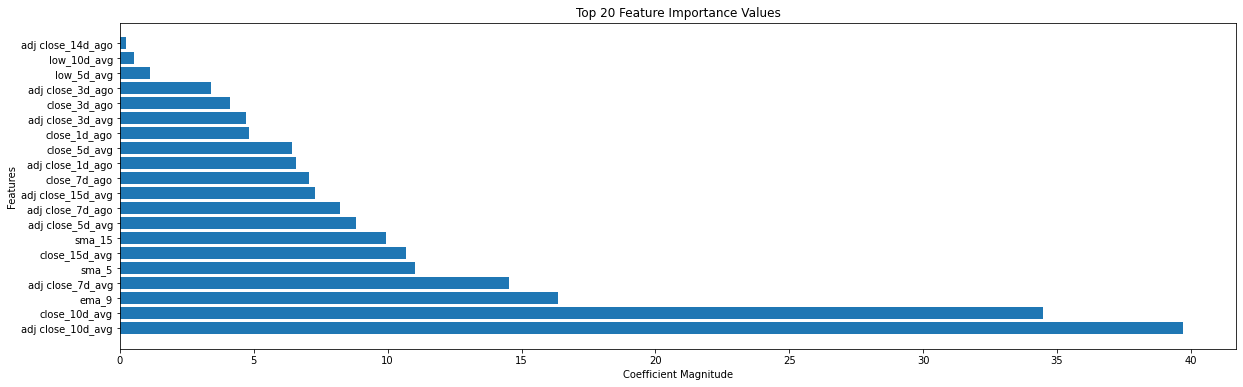

Feature  Importance
0   adj close_10d_avg   39.701594
1       close_10d_avg   34.492844
2               ema_9   16.380613
3    adj close_7d_avg   14.543602
4               sma_5   11.032622
5       close_15d_avg   10.687774
6              sma_15    9.954755
7    adj close_5d_avg    8.830203
8    adj close_7d_ago    8.207036
9   adj close_15d_avg    7.303476
10       close_7d_ago    7.068989
11   adj close_1d_ago    6.587839
12       close_5d_avg    6.427914
13       close_1d_ago    4.837201
14   adj close_3d_avg    4.708264
15       close_3d_ago    4.101885
16   adj close_3d_ago    3.394063
17         low_5d_avg    1.134743
18        low_10d_avg    0.507845
19  adj close_14d_ago    0.220884

In [41]:
plot_feature_importance(lr_model20,X_train20,20)

### 3.c Linear Regression Model with top 15 Features

In [42]:
keep_cols15 = lr_base_feature_importance[:15]['Feature'].tolist()

X_train15 = X_train[keep_cols15]
X_test15 = X_test[keep_cols15]

scaler = StandardScaler()
X_train_scaled15 = scaler.fit_transform(X_train15)
X_test_scaled15 = scaler.transform(X_test15)

In [43]:
# Train the linear regression model
lr_model15 = LinearRegression()
lr_model15.fit(X_train_scaled15, y_train)

# Make predictions on the scaled test set
lr_pred15 = lr_model15.predict(X_test_scaled15)
lr_score15 = evaluate_regression_model(y_test, lr_pred15)

Mean Squared Error (MSE): 0.797
Root Mean Squared Error (RMSE): 0.893
Mean Absolute Error (MAE): 0.626
R-squared (R2): 0.981


In [44]:
prediction_df['lr_pred15'] = lr_pred15

prediction_df.head()

date     y_test  lr_pred_base  lr_pred20  lr_pred15
1729 2020-01-02  54.240002     54.157799  54.239022  54.554907
1730 2020-01-03  54.150002     54.553547  54.520826  54.558027
1731 2020-01-06  53.919998     54.336899  54.065422  54.148986
1732 2020-01-07  54.049999     53.907121  54.067429  53.903359
1733 2020-01-08  54.189999     54.192608  53.987340  53.942897

In [45]:
lr_score15

{'MSE': 0.7968925999367115,
 'RMSE': 0.8926884114497686,
 'MAE': 0.6261544545364333,
 'R2': 0.9805207932836008}

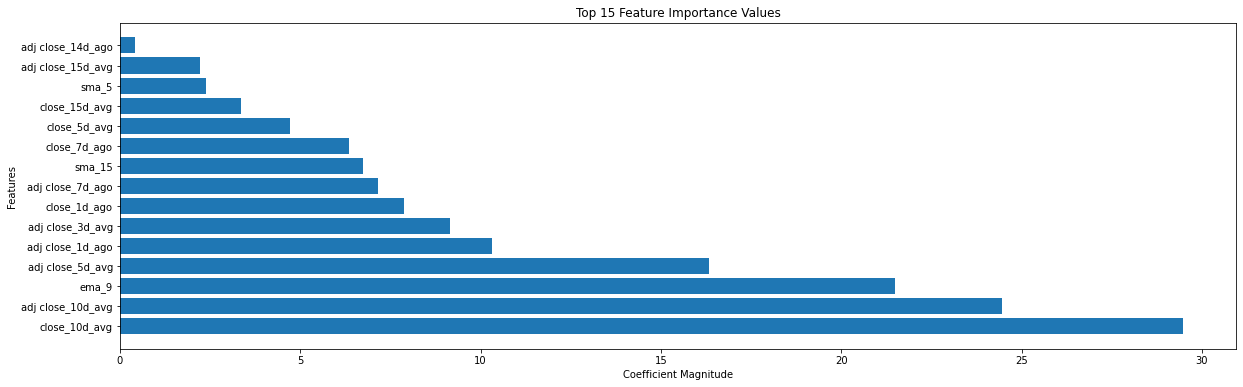

Feature  Importance
0       close_10d_avg   29.471317
1   adj close_10d_avg   24.455782
2               ema_9   21.480216
3    adj close_5d_avg   16.328249
4    adj close_1d_ago   10.320838
5    adj close_3d_avg    9.162211
6        close_1d_ago    7.864891
7    adj close_7d_ago    7.162200
8              sma_15    6.734176
9        close_7d_ago    6.356886
10       close_5d_avg    4.707638
11      close_15d_avg    3.343602
12              sma_5    2.379653
13  adj close_15d_avg    2.216233
14  adj close_14d_ago    0.415949

In [46]:
plot_feature_importance(lr_model15,X_train15,15)

### 3.d. Linear Regression Model with top 10 Features

In [47]:
keep_cols10 = lr_base_feature_importance[:10]['Feature'].tolist()

X_train10 = X_train[keep_cols10]
X_test10 = X_test[keep_cols10]

scaler = StandardScaler()
X_train_scaled10 = scaler.fit_transform(X_train10)
X_test_scaled10 = scaler.transform(X_test10)

In [48]:
# Train the linear regression model
lr_model10 = LinearRegression()
lr_model10.fit(X_train_scaled10, y_train)

# Make predictions on the scaled test set
lr_pred10 = lr_model10.predict(X_test_scaled10)
lr_score10 = evaluate_regression_model(y_test, lr_pred10)

Mean Squared Error (MSE): 0.786
Root Mean Squared Error (RMSE): 0.887
Mean Absolute Error (MAE): 0.626
R-squared (R2): 0.981


In [49]:
prediction_df['lr_pred10'] = lr_pred10

prediction_df.head()

date     y_test  lr_pred_base  lr_pred20  lr_pred15  lr_pred10
1729 2020-01-02  54.240002     54.157799  54.239022  54.554907  54.590333
1730 2020-01-03  54.150002     54.553547  54.520826  54.558027  54.511431
1731 2020-01-06  53.919998     54.336899  54.065422  54.148986  54.126188
1732 2020-01-07  54.049999     53.907121  54.067429  53.903359  53.992480
1733 2020-01-08  54.189999     54.192608  53.987340  53.942897  54.081508

In [50]:
lr_score10

{'MSE': 0.7864993593280865,
 'RMSE': 0.8868479911056271,
 'MAE': 0.6260216655405225,
 'R2': 0.9807748451875646}

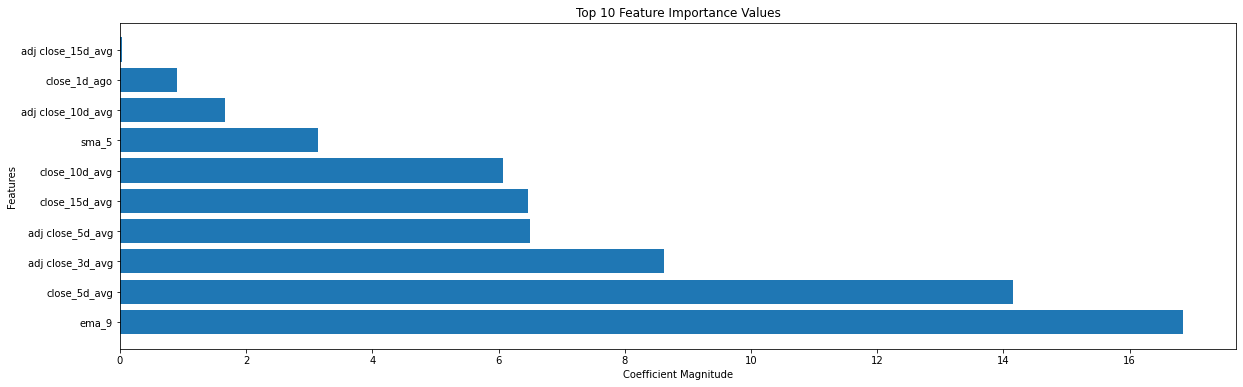

Feature  Importance
0              ema_9   16.842727
1       close_5d_avg   14.158982
2   adj close_3d_avg    8.615665
3   adj close_5d_avg    6.493537
4      close_15d_avg    6.467632
5      close_10d_avg    6.069412
6              sma_5    3.130954
7  adj close_10d_avg    1.666197
8       close_1d_ago    0.905094
9  adj close_15d_avg    0.029654

In [51]:
plot_feature_importance(lr_model10,X_train10,10)

## 4. Ridge Regression Parameter Fine Tuning

### 4.a. Ridge Regression with All Features

In [52]:
ridge_model = Ridge()

    # Define the hyperparameter grid to search
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_scaled, y_train)

    # Get the best model
best_ridge_model = grid_search.best_estimator_

    # Make predictions on the test set
ridge_pred_base = best_ridge_model.predict(X_test_scaled)

    # Evaluate the best model
mse = mean_squared_error(y_test, ridge_pred_base)
rmse = mean_squared_error(y_test, ridge_pred_base, squared=False)
mae = mean_absolute_error(y_test, ridge_pred_base)
r2 = r2_score(y_test, ridge_pred_base)

print("Best Ridge Regression Model:")
print(f"Best alpha: {best_ridge_model.alpha}")
print(f'Root Mean Squared Error (RMSE): {np.round(rmse,3)}')
print(f"Mean Squared Error: {np.round(mse,3)}")
print(f"Mean Absolute Error: {np.round(mae,3)}")
print(f"R2 Score: {np.round(r2,3)}")

ridge_score = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

Best Ridge Regression Model:
Best alpha: 0.001
Root Mean Squared Error (RMSE): 0.871
Mean Squared Error: 0.759
Mean Absolute Error: 0.606
R2 Score: 0.981


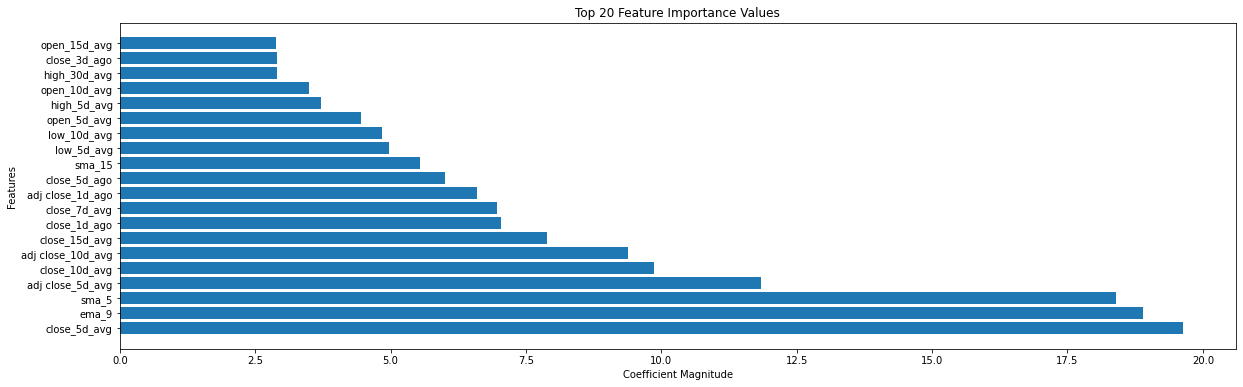

In [53]:
ridge_base_feature_importance = plot_feature_importance(best_ridge_model,X_train,20)

In [54]:
ridge_base_feature_importance[:20]

Feature  Importance
0        close_5d_avg   19.627386
1               ema_9   18.897025
2               sma_5   18.403314
3    adj close_5d_avg   11.844801
4       close_10d_avg    9.872194
5   adj close_10d_avg    9.389002
6       close_15d_avg    7.887685
7        close_1d_ago    7.038813
8        close_7d_avg    6.958126
9    adj close_1d_ago    6.600528
10       close_5d_ago    6.008206
11             sma_15    5.538994
12         low_5d_avg    4.965283
13        low_10d_avg    4.840114
14        open_5d_avg    4.446916
15        high_5d_avg    3.714418
16       open_10d_avg    3.486739
17       high_30d_avg    2.896473
18       close_3d_ago    2.893431
19       open_15d_avg    2.892245

In [55]:
prediction_df['ridge_pred_base'] = ridge_pred_base

prediction_df.head()

date     y_test  lr_pred_base  lr_pred20  lr_pred15  lr_pred10  \
1729 2020-01-02  54.240002     54.157799  54.239022  54.554907  54.590333   
1730 2020-01-03  54.150002     54.553547  54.520826  54.558027  54.511431   
1731 2020-01-06  53.919998     54.336899  54.065422  54.148986  54.126188   
1732 2020-01-07  54.049999     53.907121  54.067429  53.903359  53.992480   
1733 2020-01-08  54.189999     54.192608  53.987340  53.942897  54.081508   

      ridge_pred_base  
1729        54.205840  
1730        54.542331  
1731        54.345656  
1732        53.873857  
1733        54.195624

### 4.b. Ridge Regression with top 20 Features

In [56]:
keep_cols20 = ridge_base_feature_importance[:20]['Feature'].tolist()

X_train20 = X_train[keep_cols20]
X_test20 = X_test[keep_cols20]

scaler = StandardScaler()
X_train_scaled20 = scaler.fit_transform(X_train20)
X_test_scaled20 = scaler.transform(X_test20)

# Train model
ridge_model20 = Ridge(alpha=0.001)
ridge_model20.fit(X_train_scaled20, y_train)


# Make predictions on the scaled test set
ridge_pred20 = ridge_model20.predict(X_test_scaled20)
ridge_score20 = evaluate_regression_model(y_test, ridge_pred20)

Mean Squared Error (MSE): 0.73
Root Mean Squared Error (RMSE): 0.854
Mean Absolute Error (MAE): 0.586
R-squared (R2): 0.982


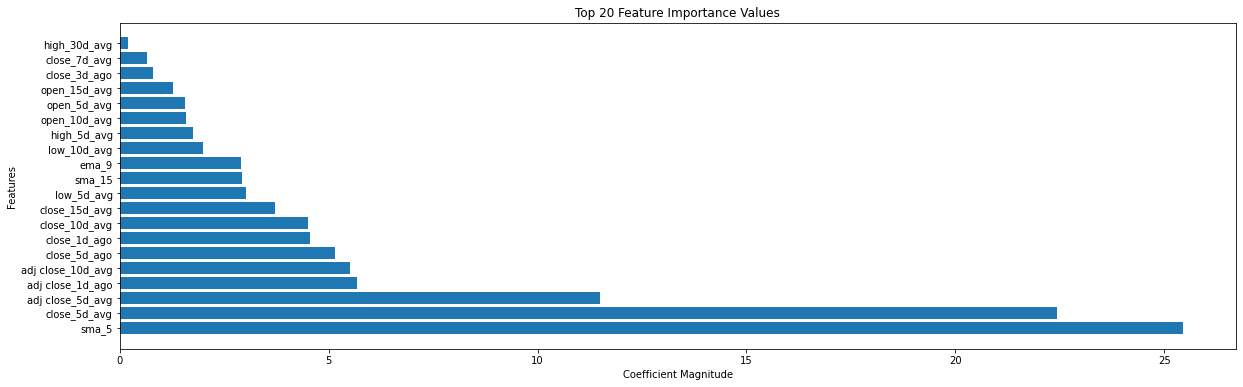

Feature  Importance
0               sma_5   25.441510
1        close_5d_avg   22.435160
2    adj close_5d_avg   11.490239
3    adj close_1d_ago    5.671591
4   adj close_10d_avg    5.507894
5        close_5d_ago    5.147037
6        close_1d_ago    4.554521
7       close_10d_avg    4.509604
8       close_15d_avg    3.719596
9          low_5d_avg    3.022988
10             sma_15    2.915010
11              ema_9    2.899160
12        low_10d_avg    1.985008
13        high_5d_avg    1.745675
14       open_10d_avg    1.590243
15        open_5d_avg    1.561036
16       open_15d_avg    1.264441
17       close_3d_ago    0.798379
18       close_7d_avg    0.640924
19       high_30d_avg    0.200250

In [57]:
plot_feature_importance(ridge_model20,X_train20,20)

In [58]:
prediction_df['ridge_pred20'] = ridge_pred20

prediction_df.head()

date     y_test  lr_pred_base  lr_pred20  lr_pred15  lr_pred10  \
1729 2020-01-02  54.240002     54.157799  54.239022  54.554907  54.590333   
1730 2020-01-03  54.150002     54.553547  54.520826  54.558027  54.511431   
1731 2020-01-06  53.919998     54.336899  54.065422  54.148986  54.126188   
1732 2020-01-07  54.049999     53.907121  54.067429  53.903359  53.992480   
1733 2020-01-08  54.189999     54.192608  53.987340  53.942897  54.081508   

      ridge_pred_base  ridge_pred20  
1729        54.205840     54.349344  
1730        54.542331     54.381596  
1731        54.345656     54.233187  
1732        53.873857     54.036503  
1733        54.195624     54.059649

## 5. Lasso Regression Model Parameter Fine Tuning

### 5.a Lasso Regression with All Features

In [59]:
lasso_model = Lasso()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_scaled, y_train)

    # Get the best model
best_lasso_model = grid_search.best_estimator_

    # Make predictions on the test set
lasso_pred_base = best_lasso_model.predict(X_test_scaled)

    # Evaluate the best model
mse = mean_squared_error(y_test, lasso_pred_base)
rmse = mean_squared_error(y_test, lasso_pred_base, squared=False)
mae = mean_absolute_error(y_test, lasso_pred_base)
r2 = r2_score(y_test, lasso_pred_base)

print("Best Lasso Regression Model:")
print(f"Best alpha: {best_lasso_model.alpha}")
print(f'Root Mean Squared Error (RMSE): {np.round(rmse,3)}')
print(f"Mean Squared Error: {np.round(mse,3)}")
print(f"Mean Absolute Error: {np.round(mae,3)}")
print(f"R2 Score: {np.round(r2,3)}")

lasso_score = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

Best Lasso Regression Model:
Best alpha: 0.001
Root Mean Squared Error (RMSE): 0.97
Mean Squared Error: 0.94
Mean Absolute Error: 0.663
R2 Score: 0.977


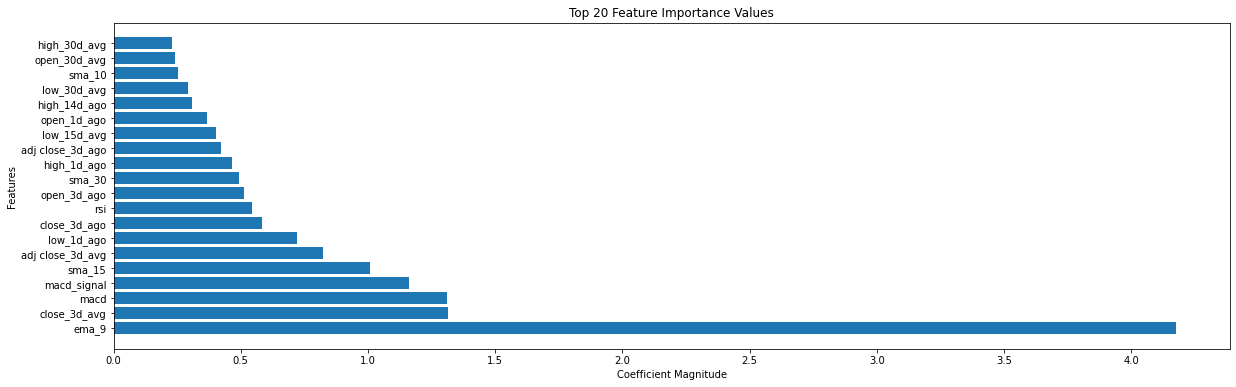

In [60]:
lasso_base_feature_importance = plot_feature_importance(best_lasso_model,X_train,20)

In [61]:
lasso_base_feature_importance[:20]

Feature  Importance
0              ema_9    4.177865
1       close_3d_avg    1.314731
2               macd    1.312350
3        macd_signal    1.160117
4             sma_15    1.006266
5   adj close_3d_avg    0.822478
6         low_1d_ago    0.722646
7       close_3d_ago    0.583764
8                rsi    0.543082
9        open_3d_ago    0.510853
10            sma_30    0.492814
11       high_1d_ago    0.466770
12  adj close_3d_ago    0.422750
13       low_15d_avg    0.404237
14       open_1d_ago    0.365671
15      high_14d_ago    0.307277
16       low_30d_avg    0.291303
17            sma_10    0.255037
18      open_30d_avg    0.241245
19      high_30d_avg    0.227913

In [62]:
prediction_df['lasso_pred_base'] = lasso_pred_base

prediction_df.head()

date     y_test  lr_pred_base  lr_pred20  lr_pred15  lr_pred10  \
1729 2020-01-02  54.240002     54.157799  54.239022  54.554907  54.590333   
1730 2020-01-03  54.150002     54.553547  54.520826  54.558027  54.511431   
1731 2020-01-06  53.919998     54.336899  54.065422  54.148986  54.126188   
1732 2020-01-07  54.049999     53.907121  54.067429  53.903359  53.992480   
1733 2020-01-08  54.189999     54.192608  53.987340  53.942897  54.081508   

      ridge_pred_base  ridge_pred20  lasso_pred_base  
1729        54.205840     54.349344        54.496024  
1730        54.542331     54.381596        54.190970  
1731        54.345656     54.233187        53.975755  
1732        53.873857     54.036503        53.828707  
1733        54.195624     54.059649        54.002350

### 5.b Lasso Regression with Top 20 Features

In [63]:
keep_cols20 = lasso_base_feature_importance[:20]['Feature'].tolist()

X_train20 = X_train[keep_cols20]
X_test20 = X_test[keep_cols20]

scaler = StandardScaler()
X_train_scaled20 = scaler.fit_transform(X_train20)
X_test_scaled20 = scaler.transform(X_test20)

# Train model
lasso_model20 = Lasso(alpha=0.001)
lasso_model20.fit(X_train_scaled20, y_train)


# Make predictions on the scaled test set
lasso_pred20 = lasso_model20.predict(X_test_scaled20)
lasso_score20 = evaluate_regression_model(y_test, lasso_pred20)

Mean Squared Error (MSE): 0.948
Root Mean Squared Error (RMSE): 0.974
Mean Absolute Error (MAE): 0.665
R-squared (R2): 0.977


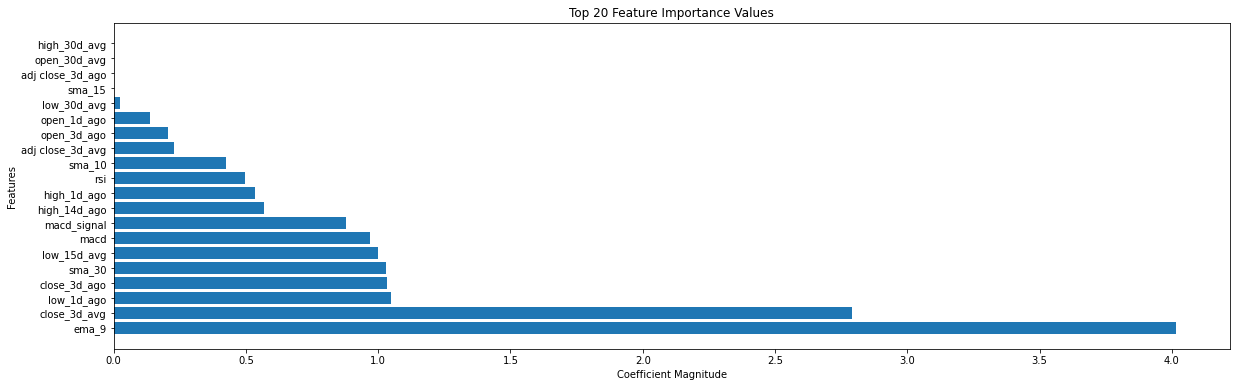

Feature  Importance
0              ema_9    4.017287
1       close_3d_avg    2.790781
2         low_1d_ago    1.047406
3       close_3d_ago    1.034968
4             sma_30    1.029511
5        low_15d_avg    0.997798
6               macd    0.968169
7        macd_signal    0.880009
8       high_14d_ago    0.568316
9        high_1d_ago    0.533765
10               rsi    0.496376
11            sma_10    0.423288
12  adj close_3d_avg    0.228550
13       open_3d_ago    0.204478
14       open_1d_ago    0.139447
15       low_30d_avg    0.025033
16            sma_15    0.000000
17  adj close_3d_ago    0.000000
18      open_30d_avg    0.000000
19      high_30d_avg    0.000000

In [64]:
plot_feature_importance(lasso_model20,X_train20,20)

In [65]:
prediction_df['lasso_pred20'] = lasso_pred20

prediction_df.head()

date     y_test  lr_pred_base  lr_pred20  lr_pred15  lr_pred10  \
1729 2020-01-02  54.240002     54.157799  54.239022  54.554907  54.590333   
1730 2020-01-03  54.150002     54.553547  54.520826  54.558027  54.511431   
1731 2020-01-06  53.919998     54.336899  54.065422  54.148986  54.126188   
1732 2020-01-07  54.049999     53.907121  54.067429  53.903359  53.992480   
1733 2020-01-08  54.189999     54.192608  53.987340  53.942897  54.081508   

      ridge_pred_base  ridge_pred20  lasso_pred_base  lasso_pred20  
1729        54.205840     54.349344        54.496024     54.501734  
1730        54.542331     54.381596        54.190970     54.262946  
1731        54.345656     54.233187        53.975755     54.001497  
1732        53.873857     54.036503        53.828707     53.859163  
1733        54.195624     54.059649        54.002350     53.989285

## 6. Elastic Net Regression Model Parameter Fine Tuning

### 6.a. Elastic Net with All Features

In [66]:
elastic_net_model = ElasticNet()

    # Define the hyperparameter grid to search
param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }

    # Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=elastic_net_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_scaled, y_train)

    # Get the best model
best_elastic_net_model = grid_search.best_estimator_

    # Make predictions on the test set
elastic_pred_base = best_elastic_net_model.predict(X_test_scaled)

    # Evaluate the best model
mse = mean_squared_error(y_test, elastic_pred_base)
rmse = mean_squared_error(y_test, elastic_pred_base, squared=False)
mae = mean_absolute_error(y_test, elastic_pred_base)
r2 = r2_score(y_test, elastic_pred_base)

print("Best Elastic Net Model:")
print(f"Best alpha: {best_elastic_net_model.alpha}")
print(f"Best l1_ratio: {best_elastic_net_model.l1_ratio}")
print(f'Root Mean Squared Error (RMSE): {np.round(rmse,3)}')
print(f"Mean Squared Error: {np.round(mse,3)}")
print(f"Mean Absolute Error: {np.round(mae,3)}")
print(f"R2 Score: {np.round(r2,3)}")

elastic_score = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

Best Elastic Net Model:
Best alpha: 0.001
Best l1_ratio: 0.1
Root Mean Squared Error (RMSE): 0.953
Mean Squared Error: 0.908
Mean Absolute Error: 0.653
R2 Score: 0.978


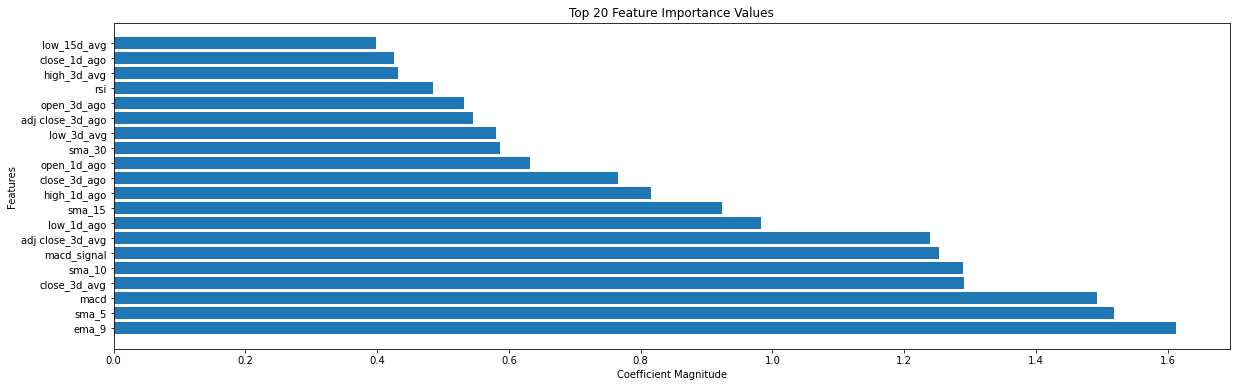

In [67]:
elastic_base_feature_importance = plot_feature_importance(best_elastic_net_model,X_train,20)

In [68]:
elastic_base_feature_importance[:20]

Feature  Importance
0              ema_9    1.613307
1              sma_5    1.518359
2               macd    1.493389
3       close_3d_avg    1.290926
4             sma_10    1.289912
5        macd_signal    1.253588
6   adj close_3d_avg    1.239816
7         low_1d_ago    0.982940
8             sma_15    0.923173
9        high_1d_ago    0.815800
10      close_3d_ago    0.765736
11       open_1d_ago    0.631358
12            sma_30    0.586684
13        low_3d_avg    0.580421
14  adj close_3d_ago    0.544949
15       open_3d_ago    0.531747
16               rsi    0.485403
17       high_3d_avg    0.431768
18      close_1d_ago    0.425664
19       low_15d_avg    0.399066

In [69]:
prediction_df['elastic_pred_base'] = elastic_pred_base

prediction_df.head()

date     y_test  lr_pred_base  lr_pred20  lr_pred15  lr_pred10  \
1729 2020-01-02  54.240002     54.157799  54.239022  54.554907  54.590333   
1730 2020-01-03  54.150002     54.553547  54.520826  54.558027  54.511431   
1731 2020-01-06  53.919998     54.336899  54.065422  54.148986  54.126188   
1732 2020-01-07  54.049999     53.907121  54.067429  53.903359  53.992480   
1733 2020-01-08  54.189999     54.192608  53.987340  53.942897  54.081508   

      ridge_pred_base  ridge_pred20  lasso_pred_base  lasso_pred20  \
1729        54.205840     54.349344        54.496024     54.501734   
1730        54.542331     54.381596        54.190970     54.262946   
1731        54.345656     54.233187        53.975755     54.001497   
1732        53.873857     54.036503        53.828707     53.859163   
1733        54.195624     54.059649        54.002350     53.989285   

      elastic_pred_base  
1729          54.444972  
1730          54.198628  
1731          54.011290  
1732          53.818335  
1733          54.037049

### 6.b. Elastic Net with Top 20 Features

In [70]:
keep_cols20 = elastic_base_feature_importance[:20]['Feature'].tolist()

X_train20 = X_train[keep_cols20]
X_test20 = X_test[keep_cols20]

scaler = StandardScaler()
X_train_scaled20 = scaler.fit_transform(X_train20)
X_test_scaled20 = scaler.transform(X_test20)

# Train model
elastic_model20 = ElasticNet(alpha=0.001,l1_ratio =  0.9)
elastic_model20.fit(X_train_scaled20, y_train)


# Make predictions on the scaled test set
elastic_pred20 = elastic_model20.predict(X_test_scaled20)
elastic_score20 = evaluate_regression_model(y_test, elastic_pred20)

Mean Squared Error (MSE): 0.948
Root Mean Squared Error (RMSE): 0.974
Mean Absolute Error (MAE): 0.667
R-squared (R2): 0.977


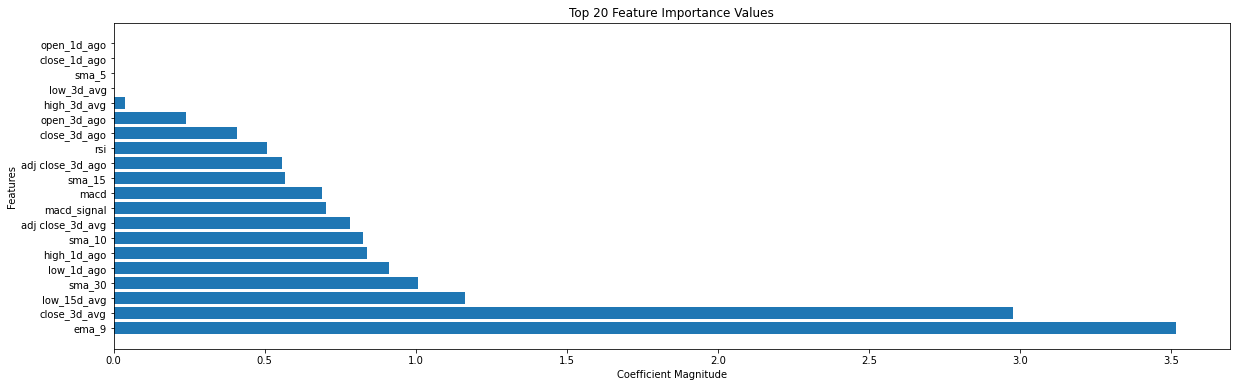

Feature  Importance
0              ema_9    3.518012
1       close_3d_avg    2.975563
2        low_15d_avg    1.164547
3             sma_30    1.008792
4         low_1d_ago    0.912273
5        high_1d_ago    0.840268
6             sma_10    0.826143
7   adj close_3d_avg    0.783827
8        macd_signal    0.701467
9               macd    0.690383
10            sma_15    0.565839
11  adj close_3d_ago    0.556647
12               rsi    0.506954
13      close_3d_ago    0.408292
14       open_3d_ago    0.238611
15       high_3d_avg    0.039417
16        low_3d_avg    0.000000
17             sma_5    0.000000
18      close_1d_ago    0.000000
19       open_1d_ago    0.000000

In [71]:
plot_feature_importance(elastic_model20,X_train20,20)

In [72]:
prediction_df['elastic_pred20'] = elastic_pred20

prediction_df.head()

date     y_test  lr_pred_base  lr_pred20  lr_pred15  lr_pred10  \
1729 2020-01-02  54.240002     54.157799  54.239022  54.554907  54.590333   
1730 2020-01-03  54.150002     54.553547  54.520826  54.558027  54.511431   
1731 2020-01-06  53.919998     54.336899  54.065422  54.148986  54.126188   
1732 2020-01-07  54.049999     53.907121  54.067429  53.903359  53.992480   
1733 2020-01-08  54.189999     54.192608  53.987340  53.942897  54.081508   

      ridge_pred_base  ridge_pred20  lasso_pred_base  lasso_pred20  \
1729        54.205840     54.349344        54.496024     54.501734   
1730        54.542331     54.381596        54.190970     54.262946   
1731        54.345656     54.233187        53.975755     54.001497   
1732        53.873857     54.036503        53.828707     53.859163   
1733        54.195624     54.059649        54.002350     53.989285   

      elastic_pred_base  elastic_pred20  
1729          54.444972       54.503795  
1730          54.198628       54.263269  
1731          54.011290       54.055709  
1732          53.818335       53.920259  
1733          54.037049       54.058664

### 7. Model Comparison

In [73]:
ela_df = pd.DataFrame([elastic_score.keys(),elastic_score.values()])
ela_df.columns = ela_df.iloc[0]
ela_df = ela_df[1:].reset_index(drop=True)
ela_df['Model'] = 'Elastic_Net with All Features'

ela_20_df = pd.DataFrame([elastic_score20.keys(),elastic_score20.values()])
ela_20_df.columns = ela_20_df.iloc[0]
ela_20_df = ela_20_df[1:].reset_index(drop=True)
ela_20_df['Model'] = 'Elastic_Net with Top 20 Features'

lasso_df = pd.DataFrame([lasso_score.keys(),lasso_score.values()])
lasso_df.columns = lasso_df.iloc[0]
lasso_df = lasso_df[1:].reset_index(drop=True)
lasso_df['Model'] = 'Lasso with All Features'

lasso_20_df = pd.DataFrame([lasso_score20.keys(),lasso_score20.values()])
lasso_20_df.columns = lasso_20_df.iloc[0]
lasso_20_df = lasso_20_df[1:].reset_index(drop=True)
lasso_20_df['Model'] = 'Lasso with Top 20 Features'

ridge_df = pd.DataFrame([ridge_score.keys(),ridge_score.values()])
ridge_df.columns = ridge_df.iloc[0]
ridge_df = ridge_df[1:].reset_index(drop=True)
ridge_df['Model'] = 'Ridge with All Features'

ridge_20_df = pd.DataFrame([ridge_score20.keys(),ridge_score20.values()])
ridge_20_df.columns = ridge_20_df.iloc[0]
ridge_20_df = ridge_20_df[1:].reset_index(drop=True)
ridge_20_df['Model'] = 'Ridge with Top 20 Features'

lr_base_df = pd.DataFrame([lr_score_base.keys(),lr_score_base.values()])
lr_base_df.columns = lr_base_df.iloc[0]
lr_base_df = lr_base_df[1:].reset_index(drop=True)
lr_base_df['Model'] = 'Linear Reg. with All Features'

lr_20_df = pd.DataFrame([lr_score20.keys(),lr_score20.values()])
lr_20_df.columns = lr_20_df.iloc[0]
lr_20_df = lr_20_df[1:].reset_index(drop=True)
lr_20_df['Model'] = 'Linear Reg. with Top 20 Features'

lr_15_df = pd.DataFrame([lr_score15.keys(),lr_score15.values()])
lr_15_df.columns = lr_15_df.iloc[0]
lr_15_df = lr_15_df[1:].reset_index(drop=True)
lr_15_df['Model'] = 'Linear Reg. with Top 15 Features'

lr_10_df = pd.DataFrame([lr_score10.keys(),lr_score10.values()])
lr_10_df.columns = lr_10_df.iloc[0]
lr_10_df = lr_10_df[1:].reset_index(drop=True)
lr_10_df['Model'] = 'Linear Reg. with Top 10 Features'

df_compare = pd.concat([ela_df,lasso_df,ridge_df,ela_20_df,lasso_20_df,ridge_20_df,
                        lr_base_df,lr_20_df,lr_15_df,lr_10_df]).sort_values(by=['R2'],ascending=False).reset_index(drop=True)

df_compare

0       MSE      RMSE       MAE        R2                             Model
0  0.729511  0.854114  0.585601  0.982168        Ridge with Top 20 Features
1  0.758611  0.870983  0.605987  0.981457           Ridge with All Features
2  0.768289  0.876521  0.613346   0.98122  Linear Reg. with Top 20 Features
3   0.77558   0.88067  0.613905  0.981042     Linear Reg. with All Features
4  0.786499  0.886848  0.626022  0.980775  Linear Reg. with Top 10 Features
5  0.796893  0.892688  0.626154  0.980521  Linear Reg. with Top 15 Features
6   0.90796  0.952869  0.652726  0.977806     Elastic_Net with All Features
7  0.940304  0.969693  0.663218  0.977015           Lasso with All Features
8  0.948047  0.973677  0.664517  0.976826        Lasso with Top 20 Features
9  0.948242  0.973777  0.666597  0.976821  Elastic_Net with Top 20 Features

After retraining the models with different alpha and input features, Ridge regression model with alpha 0.001 and all features performed best among others. 


- **Mean Squared Error (MSE) 0.729511:**

MSE measures the average squared difference between predicted and actual values. In this case, the MSE of 0.729511 is relatively low, indicating that, on average, the squared errors between predicted and actual values are small. Lower MSE values suggest better accuracy.

- **Root Mean Squared Error (RMSE) 0.854114:**

RMSE is the square root of the MSE and provides a measure of the average magnitude of the errors. A lower RMSE (0.854114) signifies that, on average, the model's predictions are close to the actual values. It is in the same unit as the target variable.

- **Mean Absolute Error (MAE) 0.585601:**

MAE measures the average absolute difference between predicted and actual values. With an MAE of 0.585601, the model's predictions, on average, deviate by approximately 0.60886 units from the actual values. Lower MAE values indicate better accuracy.

- **R-squared (R2) 0.982168:**

R2 represents the proportion of variance in the target variable that is predictable from the independent variables. An R2 value of 0.982168 is exceptionally high, indicating that the model explains about 98.21% of the variance in the closing stock prices. A higher R2 value suggests a better accuracy.


In summary, the provided accuracy scores collectively suggest that the model performs exceptionally well. The low MSE, RMSE, MAE and high R2 score indicate that the model's predictions are close to the actual values.

In [74]:
prediction_df

date     y_test  lr_pred_base  lr_pred20  lr_pred15  lr_pred10  \
1729 2020-01-02  54.240002     54.157799  54.239022  54.554907  54.590333   
1730 2020-01-03  54.150002     54.553547  54.520826  54.558027  54.511431   
1731 2020-01-06  53.919998     54.336899  54.065422  54.148986  54.126188   
1732 2020-01-07  54.049999     53.907121  54.067429  53.903359  53.992480   
1733 2020-01-08  54.189999     54.192608  53.987340  53.942897  54.081508   
...         ...        ...           ...        ...        ...        ...   
2694 2023-11-01  67.970001     67.251327  66.691627  66.293326  66.511564   
2695 2023-11-02  68.820000     68.295223  67.635666  67.398789  67.681439   
2696 2023-11-03  68.239998     68.864264  68.759090  68.689217  68.943305   
2697 2023-11-06  68.489998     68.041446  68.134383  68.593341  68.842344   
2698 2023-11-07  69.019997     68.239220  68.843554  69.136339  69.178896   

      ridge_pred_base  ridge_pred20  lasso_pred_base  lasso_pred20  \
1729        54.205840     54.349344        54.496024     54.501734   
1730        54.542331     54.381596        54.190970     54.262946   
1731        54.345656     54.233187        53.975755     54.001497   
1732        53.873857     54.036503        53.828707     53.859163   
1733        54.195624     54.059649        54.002350     53.989285   
...               ...           ...              ...           ...   
2694        67.298025     66.970336        66.962254     67.016646   
2695        68.052648     67.865085        67.502858     67.485406   
2696        68.811739     68.806564        68.155329     68.270610   
2697        68.125227     68.286008        68.186065     68.384744   
2698        68.336189     68.670691        68.368078     68.539077   

      elastic_pred_base  elastic_pred20  
1729          54.444972       54.503795  
1730          54.198628       54.263269  
1731          54.011290       54.055709  
1732          53.818335       53.920259  
1733          54.037049       54.058664  
...                 ...             ...  
2694          67.047164       67.123766  
2695          67.584452       67.672327  
2696          68.171208       68.378378  
2697          68.222377       68.472590  
2698          68.463381       68.531877  

[970 rows x 12 columns]

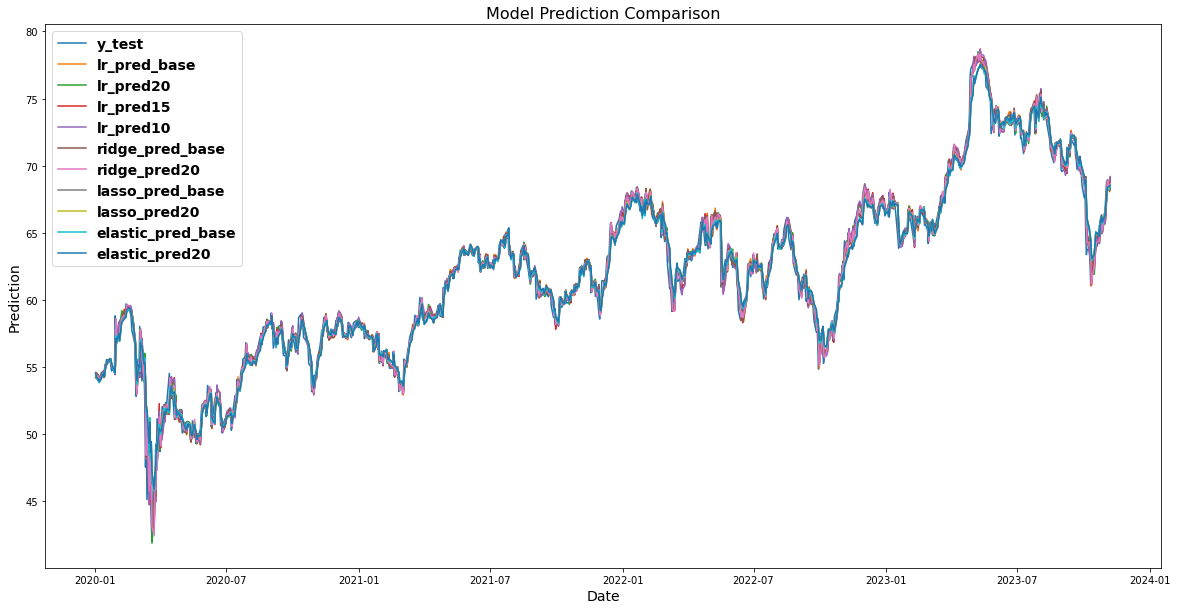

In [75]:
plt.figure(figsize=(20, 10))
sns.lineplot(x = prediction_df.date, y=prediction_df.y_test,label='y_test')

sns.lineplot(x = prediction_df.date, y=prediction_df.lr_pred_base,label='lr_pred_base')
sns.lineplot(x = prediction_df.date, y=prediction_df.lr_pred20,label='lr_pred20')
sns.lineplot(x = prediction_df.date, y=prediction_df.lr_pred15,label='lr_pred15')
sns.lineplot(x = prediction_df.date, y=prediction_df.lr_pred10,label='lr_pred10')

sns.lineplot(x = prediction_df.date, y=prediction_df.ridge_pred_base,label='ridge_pred_base')
sns.lineplot(x = prediction_df.date, y=prediction_df.ridge_pred20,label='ridge_pred20')

sns.lineplot(x = prediction_df.date, y=prediction_df.lasso_pred_base,label='lasso_pred_base')
sns.lineplot(x = prediction_df.date, y=prediction_df.lasso_pred20,label='lasso_pred20')

sns.lineplot(x = prediction_df.date, y=prediction_df.elastic_pred_base,label='elastic_pred_base')
sns.lineplot(x = prediction_df.date, y=prediction_df.elastic_pred20,label='elastic_pred20')

plt.legend(prop={'size': 14, 'weight': 'bold'})
plt.title('Model Prediction Comparison', fontsize=16)
plt.ylabel('Prediction', fontsize=14)
plt.xlabel('Date', fontsize=14)

plt.show()

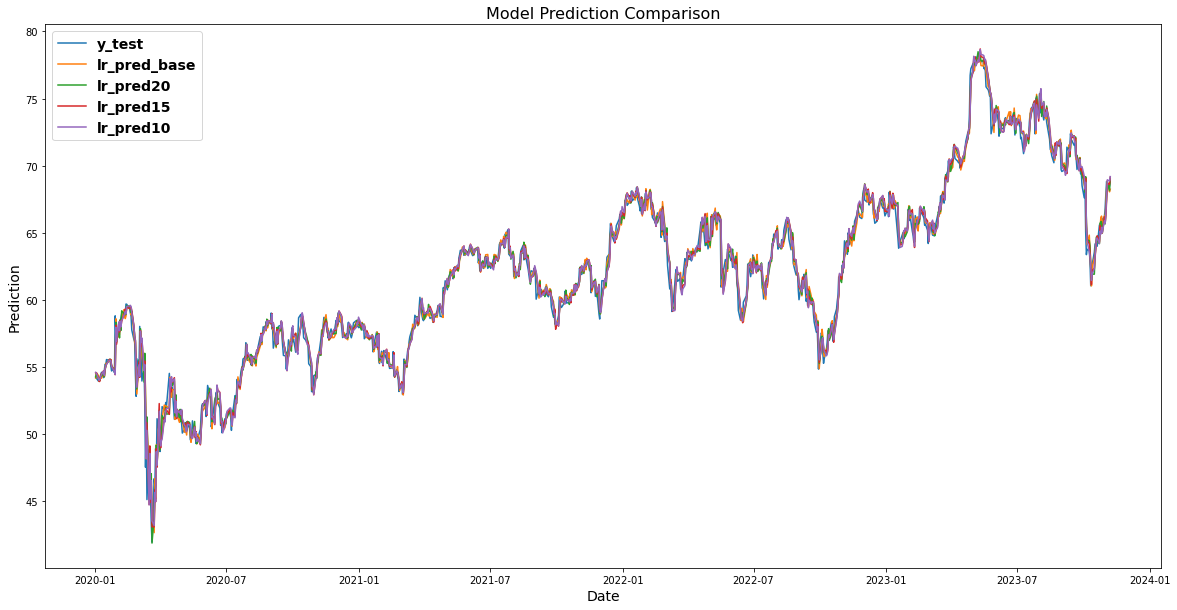

In [76]:
plt.figure(figsize=(20, 10))
sns.lineplot(x = prediction_df.date, y=prediction_df.y_test,label='y_test')

sns.lineplot(x = prediction_df.date, y=prediction_df.lr_pred_base,label='lr_pred_base')
sns.lineplot(x = prediction_df.date, y=prediction_df.lr_pred20,label='lr_pred20')
sns.lineplot(x = prediction_df.date, y=prediction_df.lr_pred15,label='lr_pred15')
sns.lineplot(x = prediction_df.date, y=prediction_df.lr_pred10,label='lr_pred10')

plt.legend(prop={'size': 14, 'weight': 'bold'})
plt.title('Model Prediction Comparison', fontsize=16)
plt.ylabel('Prediction', fontsize=14)
plt.xlabel('Date', fontsize=14)

plt.show()

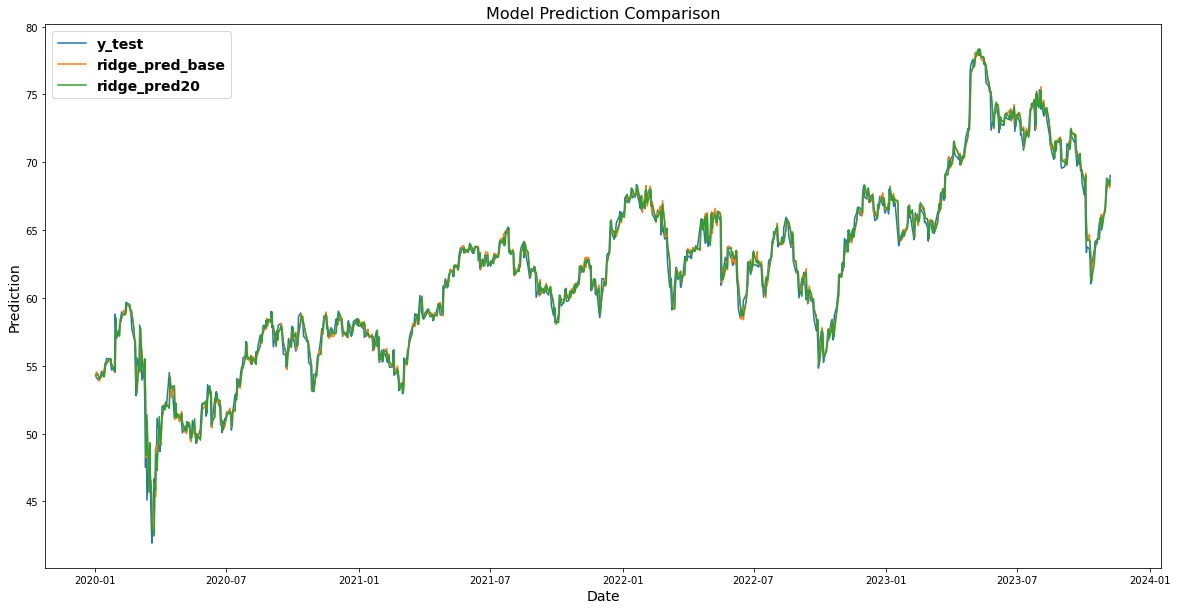

In [77]:
plt.figure(figsize=(20, 10))
sns.lineplot(x = prediction_df.date, y=prediction_df.y_test,label='y_test')

sns.lineplot(x = prediction_df.date, y=prediction_df.ridge_pred_base,label='ridge_pred_base')
sns.lineplot(x = prediction_df.date, y=prediction_df.ridge_pred20,label='ridge_pred20')

plt.legend(prop={'size': 14, 'weight': 'bold'})
plt.title('Model Prediction Comparison', fontsize=16)
plt.ylabel('Prediction', fontsize=14)
plt.xlabel('Date', fontsize=14)

plt.show()

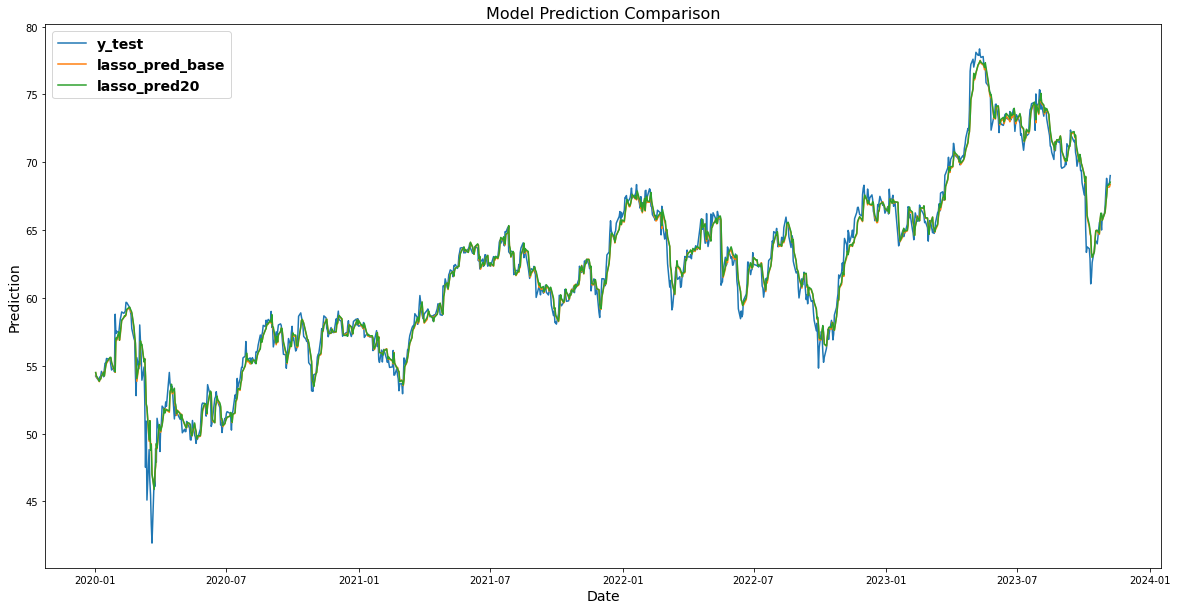

In [78]:
plt.figure(figsize=(20, 10))
sns.lineplot(x = prediction_df.date, y=prediction_df.y_test,label='y_test')

sns.lineplot(x = prediction_df.date, y=prediction_df.lasso_pred_base,label='lasso_pred_base')
sns.lineplot(x = prediction_df.date, y=prediction_df.lasso_pred20,label='lasso_pred20')

plt.legend(prop={'size': 14, 'weight': 'bold'})
plt.title('Model Prediction Comparison', fontsize=16)
plt.ylabel('Prediction', fontsize=14)
plt.xlabel('Date', fontsize=14)

plt.show()

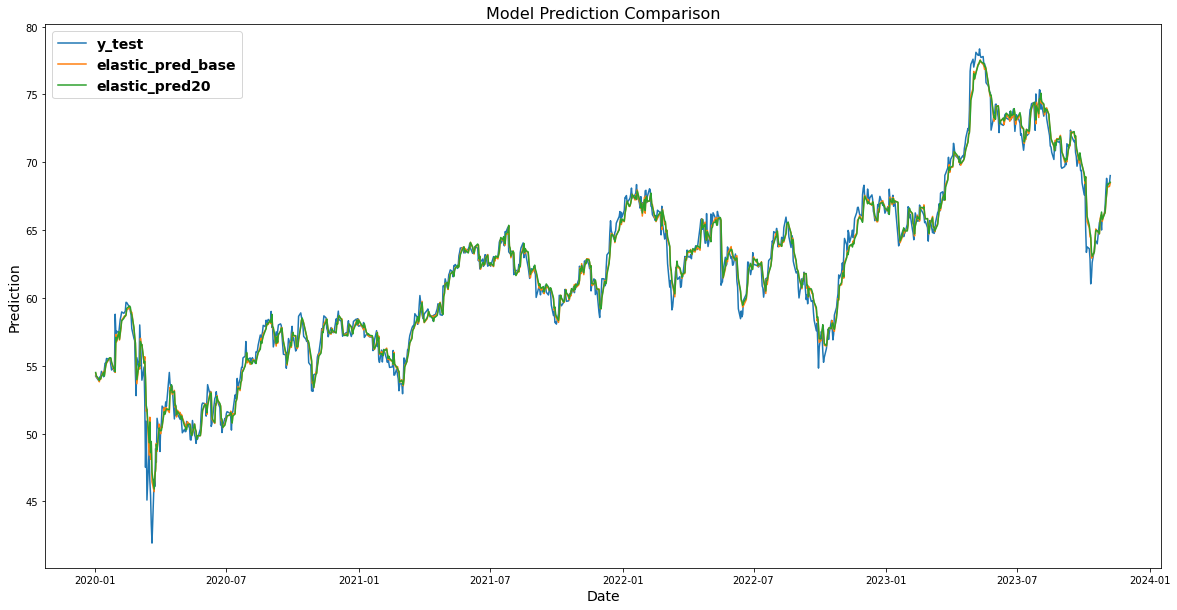

In [79]:
plt.figure(figsize=(20, 10))
sns.lineplot(x = prediction_df.date, y=prediction_df.y_test,label='y_test')

sns.lineplot(x = prediction_df.date, y=prediction_df.elastic_pred_base,label='elastic_pred_base')
sns.lineplot(x = prediction_df.date, y=prediction_df.elastic_pred20,label='elastic_pred20')

plt.legend(prop={'size': 14, 'weight': 'bold'})
plt.title('Model Prediction Comparison', fontsize=16)
plt.ylabel('Prediction', fontsize=14)
plt.xlabel('Date', fontsize=14)

plt.show()

### 7.a Final Best Model

In [80]:
# target column is next day's close price
y_train = train_df['close_1d_next'].copy()
X_train = train_df.drop(['close_1d_next'], 1)

# target column is next day's close price
y_test  = test_df['close_1d_next'].copy()
X_test  = test_df.drop(['close_1d_next'], 1)

In [81]:
ridge_20_features = ridge_base_feature_importance[:20]['Feature'].tolist()
X_train = X_train[ridge_20_features]
X_test = X_test[ridge_20_features]


In [82]:
def train_ridge_regression(X_train,X_test,y_train,y_test):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    ridge_model = Ridge(alpha=0.001)
    ridge_model.fit(X_train_scaled, y_train)


    # Make predictions on the scaled test set
    ridge_pred = ridge_model.predict(X_test_scaled)
    ridge_score = evaluate_regression_model2(y_test, ridge_pred)

    return ridge_model,ridge_pred,ridge_score


In [83]:
ridge_model, ridge_pred, ridge_score = train_ridge_regression(X_train,X_test,y_train,y_test)

In [84]:
ridge_score

{'MSE': 0.7295114881722916,
 'RMSE': 0.8541144467647714,
 'MAE': 0.5856010765186319,
 'R2': 0.9821678541358965}

In [85]:
ridge_pred[:15]

array([54.34934416, 54.38159609, 54.23318706, 54.03650291, 54.05964943,
       54.17549586, 54.25017275, 54.54902816, 54.18781481, 54.74202716,
       55.14666847, 55.18770245, 55.53205975, 55.4774224 , 55.51006433])

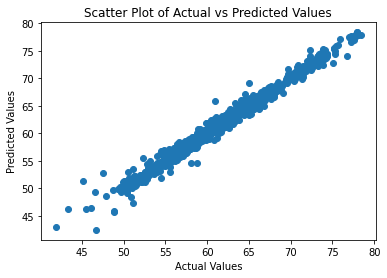

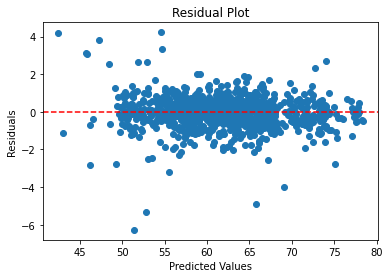

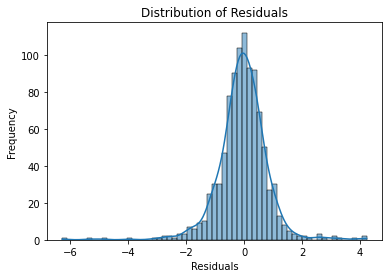

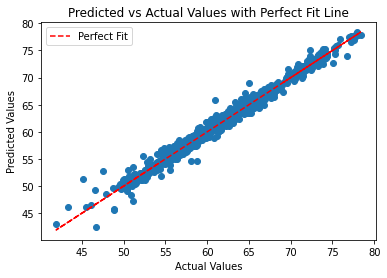

In [86]:
plot_regression_accuracy(y_test, ridge_pred)

In [87]:
plot_predictions(df,ridge_pred)

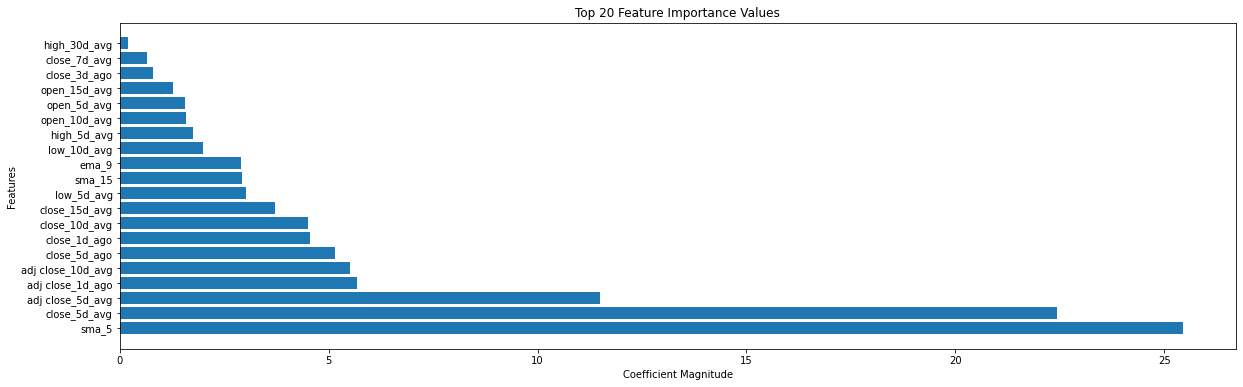

Feature  Importance
0               sma_5   25.441510
1        close_5d_avg   22.435160
2    adj close_5d_avg   11.490239
3    adj close_1d_ago    5.671591
4   adj close_10d_avg    5.507894
5        close_5d_ago    5.147037
6        close_1d_ago    4.554521
7       close_10d_avg    4.509604
8       close_15d_avg    3.719596
9          low_5d_avg    3.022988
10             sma_15    2.915010
11              ema_9    2.899160
12        low_10d_avg    1.985008
13        high_5d_avg    1.745675
14       open_10d_avg    1.590243
15        open_5d_avg    1.561036
16       open_15d_avg    1.264441
17       close_3d_ago    0.798379
18       close_7d_avg    0.640924
19       high_30d_avg    0.200250

In [88]:
plot_feature_importance(ridge_model,X_train,20)

The residual, scatter, and time series line charts above clearly show that the predicted values are very close to the actual values. These visualizations confirm that the model is very good at making accurate predictions, highlighting its strong performance and reliability in understanding the details of the data.

## 8. Train Multiple Different Stocks with Ridge Regression Model

In [89]:
def preprocess_data(df):
    df['ema_9'] = df['close'].ewm(9).mean().shift()
    df['sma_5'] = df['close'].rolling(5).mean().shift()
    df['sma_10'] = df['close'].rolling(10).mean().shift()
    df['sma_15'] = df['close'].rolling(15).mean().shift()
    df['sma_30'] = df['close'].rolling(30).mean().shift()
    df['rsi'] = rsi(df) #.fillna(0)
    df['mfi'] = mfi(df, 14)
    EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
    df['macd'] = pd.Series(EMA_12 - EMA_26)
    df['macd_signal'] = pd.Series(df.macd.ewm(span=9, min_periods=9).mean())
    df['close_1d_next'] = df['close'].shift(-1)

    df['close_1d_ago'] = df['close'].shift(1)
    df['close_3d_ago'] = df['close'].shift(3)
    df['close_5d_ago'] = df['close'].shift(5)
    df['close_1w_ago'] = df['close'].shift(7)
    df['close_2w_ago'] = df['close'].shift(14)
    df['close_3w_ago'] = df['close'].shift(21)
    df['close_4w_ago'] = df['close'].shift(28)

    df['adj_close_1d_ago'] = df['adj close'].shift(1)
    df['adj_close_3d_ago'] = df['adj close'].shift(3)
    df['adj_close_5d_ago'] = df['adj close'].shift(5)
    df['adj_close_1w_ago'] = df['adj close'].shift(7)
    df['adj_close_2w_ago'] = df['adj close'].shift(14)
    df['adj_close_3w_ago'] = df['adj close'].shift(21)
    df['adj_close_4w_ago'] = df['adj close'].shift(28)

    df['open_1d_ago'] = df['open'].shift(1)
    df['open_3d_ago'] = df['open'].shift(3)
    df['open_5d_ago'] = df['open'].shift(5)
    df['open_1w_ago'] = df['open'].shift(7)
    df['open_2w_ago'] = df['open'].shift(14)
    df['open_3w_ago'] = df['open'].shift(21)
    df['open_4w_ago'] = df['open'].shift(28)

    df['high_1d_ago'] = df['high'].shift(1)
    df['high_3d_ago'] = df['high'].shift(3)
    df['high_5d_ago'] = df['high'].shift(5)
    df['high_1w_ago'] = df['high'].shift(7)
    df['high_2w_ago'] = df['high'].shift(14)
    df['high_3w_ago'] = df['high'].shift(21)
    df['high_4w_ago'] = df['high'].shift(28)

    df['low_1d_ago'] = df['low'].shift(1)
    df['low_3d_ago'] = df['low'].shift(3)
    df['low_5d_ago'] = df['low'].shift(5)
    df['low_1w_ago'] = df['low'].shift(7)
    df['low_2w_ago'] = df['low'].shift(14)
    df['low_3w_ago'] = df['low'].shift(21)
    df['low_4w_ago'] = df['low'].shift(28)

    df['volume_1d_ago'] = df['volume'].shift(1)
    df['volume_3d_ago'] = df['volume'].shift(3)
    df['volume_5d_ago'] = df['volume'].shift(5)
    df['volume_1w_ago'] = df['volume'].shift(7)
    df['volume_2w_ago'] = df['volume'].shift(14)
    df['volume_3w_ago'] = df['volume'].shift(21)
    df['volume_4w_ago'] = df['volume'].shift(28)

    df['open_3d_avg'] = df['open'].rolling(window=3).mean()
    df['open_5d_avg'] = df['open'].rolling(window=5).mean()
    df['open_7d_avg'] = df['open'].rolling(window=7).mean()
    df['open_10d_avg'] = df['open'].rolling(window=10).mean()
    df['open_15d_avg'] = df['open'].rolling(window=15).mean()
    df['open_30d_avg'] = df['open'].rolling(window=30).mean()

    df['high_3d_avg'] = df['high'].rolling(window=3).mean()
    df['high_5d_avg'] = df['high'].rolling(window=5).mean()
    df['high_7d_avg'] = df['high'].rolling(window=7).mean()
    df['high_10d_avg'] = df['high'].rolling(window=10).mean()
    df['high_15d_avg'] = df['high'].rolling(window=15).mean()
    df['high_30d_avg'] = df['high'].rolling(window=30).mean()

    df['low_3d_avg'] = df['low'].rolling(window=3).mean()
    df['low_5d_avg'] = df['low'].rolling(window=5).mean()
    df['low_7d_avg'] = df['low'].rolling(window=7).mean()
    df['low_10d_avg'] = df['low'].rolling(window=10).mean()
    df['low_15d_avg'] = df['low'].rolling(window=15).mean()
    df['low_30d_avg'] = df['low'].rolling(window=30).mean()

    df['volume_3d_avg'] = df['volume'].rolling(window=3).mean()
    df['volume_5d_avg'] = df['volume'].rolling(window=5).mean()
    df['volume_7d_avg'] = df['volume'].rolling(window=7).mean()
    df['volume_10d_avg'] = df['volume'].rolling(window=10).mean()
    df['volume_15d_avg'] = df['volume'].rolling(window=15).mean()
    df['volume_30d_avg'] = df['volume'].rolling(window=30).mean()

    df['adj_close_3d_avg'] = df['adj close'].rolling(window=3).mean()
    df['adj_close_5d_avg'] = df['adj close'].rolling(window=5).mean()
    df['adj_close_7d_avg'] = df['adj close'].rolling(window=7).mean()
    df['adj_close_10d_avg'] = df['adj close'].rolling(window=10).mean()
    df['adj_close_15d_avg'] = df['adj close'].rolling(window=15).mean()
    df['adj_close_30d_avg'] = df['adj close'].rolling(window=30).mean()
    
    return df

In [90]:
df_all = pd.read_parquet(out_loc+"stock_1d.parquet")
df_all.columns = df_all.columns.str.lower()

In [91]:
### keep stocks in data with min year 2013, max year 2023
stock_min_dt = pd.DataFrame(df_all.groupby('symbol')['date'].min()).reset_index().rename(columns={'date':'min_date'})
stock_max_dt = pd.DataFrame(df_all.groupby('symbol')['date'].max()).reset_index().rename(columns={'date':'max_date'})
stock_cnt_dt = pd.DataFrame(df_all.groupby('symbol')['date'].count()).reset_index().rename(columns={'date':'days_cnt'})

stock_cnt = stock_min_dt.merge(stock_max_dt,on='symbol').merge(stock_cnt_dt,on='symbol')
stock_cnt['min_year'] = stock_cnt['min_date'].dt.year
stock_cnt['max_year'] = stock_cnt['max_date'].dt.year

keep_stocks = stock_cnt[(stock_cnt['min_year']==2013)&(stock_cnt['max_year']==2023)&(stock_cnt['days_cnt']>=2500)]['symbol'].unique().tolist()

stock_cnt.head()

symbol   min_date   max_date  days_cnt  min_year  max_year
0      A 2013-01-02 2023-11-08      2733      2013      2023
1    AAL 2013-01-02 2023-11-08      2733      2013      2023
2   AAPL 2013-01-02 2023-11-08      2733      2013      2023
3   ABBV 2013-01-02 2023-11-08      2733      2013      2023
4   ABNB 2020-12-10 2023-11-08       733      2020      2023

In [92]:
df_2023 = df_all[(df_all.date.dt.year==2023) & (df_all.symbol.isin(keep_stocks))]
# volume vs stocks
volume_2023 = pd.DataFrame(df_2023.groupby(['symbol','security','gics sector'])['volume'].sum()).reset_index()
volume_2023 = volume_2023.sort_values(by='volume',ascending=False).reset_index(drop=True)
volume_2023.head()

symbol            security             gics sector        volume
0   TSLA         Tesla, Inc.  Consumer Discretionary  3.009291e+10
1    AMD                 AMD  Information Technology  1.342035e+10
2   AMZN              Amazon  Consumer Discretionary  1.305160e+10
3   AAPL          Apple Inc.  Information Technology  1.303964e+10
4      F  Ford Motor Company  Consumer Discretionary  1.278319e+10

In [93]:
# volume vs sectors
sector_2023 = pd.DataFrame(df_2023.groupby(['gics sector'])['volume'].sum()).reset_index()
sector_2023 = sector_2023.sort_values(by='volume',ascending=False).reset_index(drop=True)
sector_2023

gics sector        volume
0   Consumer Discretionary  9.171407e+10
1   Information Technology  8.888840e+10
2               Financials  6.728113e+10
3   Communication Services  5.267892e+10
4              Health Care  3.755560e+10
5              Industrials  3.672492e+10
6                   Energy  3.245171e+10
7         Consumer Staples  2.824873e+10
8                Utilities  2.214882e+10
9                Materials  1.432867e+10
10             Real Estate  1.318748e+10

In [94]:
# filter top 5 sectors with highest volume in 2023
sector_list = sector_2023[:5]['gics sector'].tolist()

stock_list = []

num_stocks = 5
# stocks with highest volume in each sector
for sec in sector_list:
    stock_list.append(volume_2023[volume_2023['gics sector']==sec]['symbol'][:num_stocks].tolist())
    
    
stock_list = [item for sublist in stock_list for item in sublist]

len(stock_list)

25

In [95]:
df_stocks = df_all[df_all['symbol'].isin(stock_list)].reset_index(drop=True)
df_stocks.head()

date       open       high        low      close  adj close  \
0 2013-01-02  18.003504  18.193193  17.931683  18.099348  18.099348   
1 2013-01-03  18.141392  18.316566  18.036036  18.109859  18.109859   
2 2013-01-04  18.251753  18.555305  18.210211  18.467718  18.467718   
3 2013-01-07  18.404655  18.503002  18.282784  18.387136  18.387136   
4 2013-01-08  18.406906  18.425926  18.128880  18.350851  18.350851   

        volume symbol                 security             gics sector  \
0  101550348.0  GOOGL  Alphabet Inc. (Class A)  Communication Services   
1   92635272.0  GOOGL  Alphabet Inc. (Class A)  Communication Services   
2  110429460.0  GOOGL  Alphabet Inc. (Class A)  Communication Services   
3   66161772.0  GOOGL  Alphabet Inc. (Class A)  Communication Services   
4   66976956.0  GOOGL  Alphabet Inc. (Class A)  Communication Services   

              gics sub-industry      headquarters location  date added  \
0  Interactive Media & Services  Mountain View, California  2014-04-03   
1  Interactive Media & Services  Mountain View, California  2014-04-03   
2  Interactive Media & Services  Mountain View, California  2014-04-03   
3  Interactive Media & Services  Mountain View, California  2014-04-03   
4  Interactive Media & Services  Mountain View, California  2014-04-03   

       cik founded  
0  1652044    1998  
1  1652044    1998  
2  1652044    1998  
3  1652044    1998  
4  1652044    1998

In [96]:
stock_compare = []

for stock in stock_list:
        stock_data = df_stocks[df_stocks['symbol'] == stock]
        stock_data = preprocess_data(stock_data)
        stock_data = stock_data.dropna().reset_index(drop=True)
        
                # Split the DataFrame into training and testing sets
        train_df_temp = stock_data[stock_data.date.dt.year<2020]
        test_df_temp = stock_data[stock_data.date.dt.year>=2020]

        drop_cols1 = ['date','open','high','low','close','adj close','volume','symbol','security',
         'gics sector','gics sub-industry','headquarters location','date added','cik','founded']

        train_df_temp = train_df_temp.drop(drop_cols1, 1)

        test_df_temp  = test_df_temp.drop(drop_cols1, 1)

        # target column is next day's close price
        y_train_temp = train_df_temp['close_1d_next'].copy()
        X_train_temp = train_df_temp.drop(['close_1d_next'], 1)

        # target column is next day's close price
        y_test_temp  = test_df_temp['close_1d_next'].copy()
        X_test_temp  = test_df_temp.drop(['close_1d_next'], 1)
#        print(stock, len(X_train), len(X_test), len(y_train), len(y_test))
        temp_model, temp_pred, temp_score = train_ridge_regression(X_train_temp,X_test_temp,y_train_temp,y_test_temp)
        
        score_df = pd.DataFrame([temp_score.keys(),temp_score.values()])
        score_df.columns = score_df.iloc[0]
        score_df = score_df[1:].reset_index(drop=True)
        score_df['symbol'] = stock
        
        stock_compare.append(score_df)
        
compare_df = pd.concat(stock_compare).sort_values(by='R2',ascending=False).reset_index(drop =True)

In [97]:
compare_df

0         MSE      RMSE       MAE        R2 symbol
0   56.919689  7.544514  5.112978  0.995061   NVDA
1    0.559182  0.747785  0.529467  0.993251     VZ
2    7.770865  2.787627  2.107652  0.992581   AAPL
3    5.039335  2.244846  1.670374  0.992108   GOOG
4     4.98575  2.232879  1.654225  0.992002  GOOGL
5   46.381058  6.810364  4.690443  0.990596   META
6    2.057386  1.434359  1.020137  0.990386    CVS
7    0.147953  0.384647  0.271314  0.990362      F
8     1.27562  1.129434  0.839937   0.98989     GM
9   28.055837  5.296776  3.992424  0.989314   MSFT
10  84.835254  9.210606  6.497099  0.988764   TSLA
11   0.575533  0.758639   0.55086  0.988709    PFE
12   0.581909   0.76283  0.577919  0.988411    BAC
13    0.26222  0.512075  0.377068  0.988041    KEY
14    1.80572  1.343771  0.958788  0.987257   INTC
15   0.991949  0.995966  0.734726  0.987031    WFC
16  11.147927  3.338851  2.469883  0.985621   AMZN
17   0.174755  0.418037  0.281833  0.983153      T
18  10.145635  3.185221  2.328928  0.982675    AMD
19   2.409729   1.55233  1.141577  0.981822      C
20   0.124353  0.352637  0.259468  0.979688   HBAN
21   0.870412  0.932958  0.684029  0.978487    BMY
22   2.087087  1.444675  1.154954   0.96863    CCL
23   4.398395  2.097235   1.52279  0.967914    JNJ
24   4.070663  2.017589  1.528408  0.589411   VTRS

The final phase of the project involved applying the developed model to real-world scenarios. By identifying the top 5 industries with the highest volume in 2023, we ensured that our predictions were grounded in current market dynamics. The subsequent selection of 5 stocks within each industry added a layer of practicality to our findings.

The model's stellar performance on NVDA, AAPL, VZ, GOOG, and GOOGL proved its robustness in diverse market conditions. Simultaneously, the challenges encountered with VTRS opened up opportunities for further investigation into the factors contributing to its underperformance.